# 2021-06-22
### Problem statement:
Gdoc: https://docs.google.com/document/d/1xYIV3xRNxTjUaw1fBkwB0ujJxUH6l7Gc1Mrskzny6JI/edit?usp=sharing

Trying to track ROI target by adjusting cpc - assume that RPC doesnt change w/ cpc
```
ROI_obs = RPC_obs / CPC_obs
ROI_target = RPC_obs / CPC_target
ROI_obs * CPC_obs = ROI_target * CPC_target
CPC_target = ROI_obs/ROI_target * CPC_obs = RPC_obs / ROI_target
```
Currently we calculate `RPC_obs` against real data - but monietization data may be spares - or u may have to go so far in the past that it no longer apllies to present


### Domain (for Taboola)
Biddable Dimensions:
1. Location (DMA)
2. Operating System
3. Device Type
4. Publisher (website ad was served on)
5. Time of Day

### Evaluation
Difficult to evaulate using real data b/c the fundamental problem we try to solve is how to measure the underlying distribution.  What we can do instead is simulate the effect of split variables and monetiation changes by taking a very coarse rps aggregation (I use `traffic_source`) and then sub-aggregate on random split variables.  We can then assign random pushes to each categorial val of the random split values - as well as introduce a RPL step in the time dimension.  Then - b/c our real split is coarse so we essentially know the real underlying rps day to day - we also know the underlying rps distribution of our simulated splits day-to-day.  Then - our methods of estimatinc rpc from sparse data can be evaluated.  Additionally - since we have a simulated monetization change, we also know how our rpc estimation methods respond to monetization changes.

### Current approach:
- we cluster similarly performing buckets w/in splits together using historical data over a large time window
- this allows us to aggregate bucket data w/in clusters to have more data available for estimation on a shorter time window - say 1 or 7 day
- the split we want to use for taboola (campaign_id x dma x os x device x publisher) is so granular that we lack enough historical data to cluster on
- as a result - I decided to cluster on (campaign_id x publisher) and (dma x os x device) separately - and then estimate rps directly over the cross product of these clusters

### Usage/Examples: 
- hey! - @jdvalle @trevor - I put some usage & examples below

In [1]:
import sys
import re
import os
# detect if we are running from a `notebooks/*_shared` folder
# re.match("not.*shared",sys.path[0])
if sys.path[0].endswith("_shared"):
    sys.path[0] = "/".join(sys.path[0].split("/")[:-2])
assert sys.path[0].endswith("adtech")

from utils.env import load_env_from_aws
load_env_from_aws()

from ds_utils.db.connectors import HealthcareDW
from notebooks.aduriseti_shared.utils import *

import functools
import collections
import itertools
import datetime
import pprint

import pandas as pd
import numpy as np
from IPython.display import display as ipydisp   
from matplotlib import pyplot as plt

from models.utils import wavg

TABOOLA = "TABOOLA"
MEDIA_ALPHA = "MEDIAALPHA"
BING = "BING"
U65 = "HEALTH"
O65 = 'MEDICARE'

NOW = datetime.datetime.now()
DAY = datetime.timedelta(days=1)

start_date = datetime.datetime(2021,4,1).date()
end_date = NOW
# start_date = NOW-30*DAY
# end_date = NOW
# start_date = NOW-60*DAY
# end_date = NOW-30*DAY
product=None
traffic_source = None

from models.data.queries.lead_score import \
    refresh_session_scores, \
    SCHEMA as DS_SCHEMA, \
    SCORE_TABLE
# df = refresh_session_scores(NOW-360*DAY,NOW)
# df

# with HealthcareDW() as db:
#     df = db.to_df(
#         """
#         SELECT
#             UPPER(traffic_source) as traffic_source_norm,
#             COUNT(*) as cnt
#         FROM 
#             tracking.session_detail
#         GROUP BY traffic_source_norm
#         ORDER BY cnt DESC
#         """
#     )

# df.head(20)

GOOGLE = "GOOGLE"
BING = "BING"
PERFORMMEDIA = "PERFORMMEDIA"
MEDIAALPHA = "MEDIAALPHA"
FACEBOOK = "FACEBOOK"
SUREHITS = "SUREHITS"
TABOOLA = "TABOOLA"
YAHOO = "YAHOO"
MAJOR_TRAFFIC_SOURCES = [
    GOOGLE,BING,PERFORMMEDIA,MEDIAALPHA,FACEBOOK,
#     SUREHITS,
    TABOOLA,
#     YAHOO,
]
MAJOR_TRAFFIC_SOURCES

Attempting to load environ from: `SM_ENV_BASE`
...Success!!


['GOOGLE', 'BING', 'PERFORMMEDIA', 'MEDIAALPHA', 'FACEBOOK', 'TABOOLA']

In [2]:
def get_unified_session_sql(start_date,end_date,product,traffic_source):
    start_date = start_date.date() if isinstance(start_date,datetime.datetime) else start_date
    end_date = end_date.date() if isinstance(end_date,datetime.datetime) else end_date
    product_filter = "" if product is None else \
        f"AND UPPER(s.product) = UPPER('{product}')"
    
    if traffic_source is None:
        traffic_filter = ""
    elif isinstance(traffic_source,(list,tuple,set)):
#         traffic_source_str = ",".join(f"'{src.upper()}'" for src in traffic_source)
        traffic_filter = f"AND UPPER(s.traffic_source) in {tuple(traffic_source)}"
    else:
        traffic_filter = \
            f"AND UPPER(s.traffic_source) = '{traffic_source.upper()}'"
        
    session_revenue_sql = f"""
    SELECT
        session_id,
        sum(revenue) AS revenue
    FROM tron.session_revenue s
    WHERE session_creation_date::DATE BETWEEN '{start_date}' AND '{end_date}'
        {product_filter}
        {traffic_filter}
    GROUP BY 1
    """
    geoip_sql = f"""
    SELECT 
        l.*,
        b.netowrk_index,
        b.start_int,
        b.end_int
    FROM 
        data_science.maxmind_ipv4_geo_blocks AS b
        JOIN data_science.maxmind_geo_locations AS l
            ON b.maxmind_id = l.maxmind_id
    """
    score_pivot_sql = f"""
        SELECT  
            session_id,
            computed_dt,
            MAX(score_null) AS score_null,
            MAX(score_adv) AS score_adv,
            MAX(score_supp) AS score_supp
        FROM {DS_SCHEMA}.{SCORE_TABLE} 
        WHERE 
            '{start_date}'::DATE <= computed_dt AND computed_dt < '{end_date}'::DATE 
        GROUP BY
            session_id,computed_dt
    """
    session_score_sql = f"""
        SELECT 
            *
        FROM (
            SELECT  
                *,
                ROW_NUMBER() OVER (PARTITION BY session_id ORDER BY computed_dt DESC) as compute_order
            FROM ({score_pivot_sql})
        )
        WHERE compute_order = 1
    """
    unified_session_sql = f"""
    WITH
        rps AS ({session_revenue_sql}),
        ip_locs AS ({geoip_sql}),
        lead_scores AS ({session_score_sql})
    SELECT
        UPPER(s.traffic_source) as traffic_source,
        s.browser,
        s.operating_system,
        s.device,
        s.channel,
        s.domain,
        s.product,
        s.keyword,
        s.campaign_id,
        s.landing_page,
        s.session_id,
        s.creation_date::DATE                                   AS utc_dt,
        s.creation_date                                         AS utc_ts,
        extract(
            HOUR FROM
            convert_timezone('UTC', l.time_zone, s.creation_date) 
                - s.creation_date
        )::INT                                                  AS utc_offset,
        l.time_zone,
        convert_timezone('UTC', l.time_zone, s.creation_date)   AS user_ts,
        date_part(DOW, user_ts)::INT                            AS dayofweek,
        date_part(HOUR, user_ts) +
        CASE 
            WHEN date_part(MINUTE, user_ts)::INT BETWEEN 0 AND 14 THEN 0.0
            WHEN date_part(MINUTE, user_ts)::INT BETWEEN 15 AND 29 THEN 0.25
            WHEN date_part(MINUTE, user_ts)::INT BETWEEN 30 AND 44 THEN 0.5
            WHEN date_part(MINUTE, user_ts)::INT BETWEEN 45 AND 59 THEN 0.75
        END                                                     AS hourofday,
        l.subdivision_1_iso_code                                AS state,
        l.metro_code                                            AS dma,
        r.revenue,
        scores.computed_dt                                      AS score_compute_dt,
        scores.score_null,
        scores.score_adv,
        scores.score_supp,
        (random() * 4)::INT                                     AS random_split_4,
        (random() * 8)::INT                                     AS random_split_8,
        (random() * 16)::INT                                    AS random_split_16,
        (random() * 32)::INT                                    AS random_split_32,
        (random() * 64)::INT                                    AS random_split_64,
        (random() * 128)::INT                                   AS random_split_128,
        (4.0   / 16 * (
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()))::INT      AS random_normal_split_4,
        (8.0   / 16 * (
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()))::INT      AS random_normal_split_8,
        (16.0  / 16 * (
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()))::INT      AS random_normal_split_16,
        (32.0  / 16 * (
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()))::INT      AS random_normal_split_32,
        (64.0  / 16 * (
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()))::INT      AS random_normal_split_64,
        (128.0 / 16 * (
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()+
                random()+random()+random()+random()))::INT      AS random_normal_split_128
FROM 
        tracking.session_detail AS s
        JOIN ip_locs as l
            ON ip_index(s.ip_address) = l.netowrk_index
            AND inet_aton(s.ip_address) BETWEEN l.start_int AND l.end_int
            AND l.country_iso_code = 'US'
        INNER JOIN rps as r
            ON s.session_id = r.session_id
        LEFT JOIN lead_scores as scores
            ON s.session_id = scores.session_id
    WHERE nullif(s.ip_address, '') IS NOT null
        AND nullif(dma,'') IS NOT NULL 
        AND s.creation_date::DATE BETWEEN '{start_date}' AND '{end_date}'
        {product_filter}
        {traffic_filter}
    """
    return unified_session_sql

@functools.lru_cache()
def unified_session(start_date,end_date,product,traffic_source):
    unified_session_sql = get_unified_session_sql(start_date,end_date,product,traffic_source)
    
    with HealthcareDW() as db:
        session_df = db.to_df(unified_session_sql)
    return session_df
    
@functools.lru_cache()
def agg_rps(start_date,end_date,product,traffic_source,agg_columns):

    # from IPython.display import display as ipydisp
    # score_computed_I = ~session_rps_df["score_compute_dt"].isna()
    # session_rps_df["score_computed"] = score_computed_I
    # session_rps_df["rev>0"] = session_rps_df["revenue"] > 0
    # session_rps_df["cnt"] = 1
    # session_rps_df.groupby(["score_computed","rev>0"])[["cnt"]].count()

    agg_columns = [*agg_columns]
    unified_session_sql = get_unified_session_sql(start_date,end_date,product,traffic_source)
    agg_rps_query = f"""
    SELECT
        {','.join(agg_columns)},
        COUNT(session_id)                                                       AS sessions,
        SUM(revenue)                                                            AS revenue,
        SUM((revenue>0)::INT::FLOAT)                                            AS num_leads,
        AVG((revenue>0)::INT::FLOAT)                                            AS lps_avg,
        SUM(revenue) / CASE
            WHEN num_leads = 0 THEN 1
            ELSE num_leads
        END                                                                     AS rpl_avg,
        (SUM(revenue) / COUNT(DISTINCT session_id))::NUMERIC(8,4)               AS rps_,
        AVG(revenue)                                                            AS rps_avg,
        STDDEV(revenue)                                                         AS rps_std,
        VARIANCE(revenue)                                                       AS rps_var,
        SUM((score_null>0)::INT)                                                AS score_null_cnt,
        AVG(score_null)                                                         AS score_null_avg,
        SUM((score_adv>0)::INT)                                                 AS score_adv_cnt,
        AVG(score_adv)                                                          AS score_adv_avg,
        SUM((score_supp>0)::INT)                                                AS score_supp_cnt,
        AVG(score_supp)                                                         AS score_supp_avg,
        SUM(((score_null>0) OR (score_adv>0) OR (score_supp>0))::INT)           AS score_cnt
    FROM ({unified_session_sql})
    GROUP BY {','.join(agg_columns)}
    """
    # print(agg_rps_query)
    # print(traffic_filter)
    from ds_utils.db.connectors import HealthcareDW
    with HealthcareDW() as db:
        df = db.to_df(agg_rps_query)
    globals()["df"] = df

    delt = df["rps_avg"] - df['rps_']
    if not all(delt.abs() < 1e-3):
        print("session uniqueness assummption not satisfied")
    df = df \
        .sort_values(by=agg_columns, ascending=True) \
        .set_index(agg_columns)

    df['int_ix'] = range(len(df))

    return df

In [3]:
campaign_split_fields = dict(
    # traffic_source = ["traffic_source"],
    browser = ["browser"],
    operating_system = ["operating_system"],
    device = ["device"],
    # channel = ["channel"],
    # domain = ["domain"],
    product = ["product"],
    # keyword = ["keyword"],
    # campaign_id = ["campaign_id"],
    # landing_page = ["landing_page"],
    TOD = ["dayofweek","hourofday"],
    dma = ["dma"],
    state =["state",],
    location = ["state","dma"],
    
    dma_os=["dma", "operating_system"],
    dma_device=["dma", "device", ],
    dma_os_device=["dma", "operating_system", "device"],

    state_os=["state", "operating_system"],
    state_device=["state", "device", ],
    state_os_device=["state", "operating_system", "device"],

    location_os = ["state", "dma", "operating_system"],
    location_device=["state", "dma", "device", ],
    location_os_device = ["state", "dma", "operating_system","device"],
)

taboola_val_map = {
    "device": {
        'DESKTOP': 'DESK',
        'MOBILE': 'PHON',
        'TABLET': 'TBLT',
    },
    "operating_system": {
        "Linux": "Linux",
        'Linux armv7l': "Linux",
        'Linux armv8l': "Linux",
        'Linux x86_64': "Linux",
        'MacIntel': 'Mac OS X',
        'Win32': "Windows",
        'iPad': "iPadOS",
        'iPhone': "iOS",
        '': None,
        'ARM': None,
        'Android': 'Android',
        'Linux aarch64': "Linux",
        'Win64': "Windows",
        'Linux armv7': "Linux",
        'Linux i686': "Linux",
        'Windows': "Windows",
        "iPod touch": "iOS",
    }
}

def translate_taboola_vals(df):
    index_cols = df.index.names
    df = df.reset_index()
    for c in df.columns:
        if c in taboola_val_map:
            df[c] = df[c] \
                .map(taboola_val_map[c]) \
                .combine_first(df[c])
    df_bkp = df
    df = df \
        .groupby(index_cols) \
        .agg({
            "sessions": sum,
            "num_leads": sum,
            "lps_avg": get_wavg_by(df,"sessions"),
            "rpl_avg": get_wavg_by(df,"sessions"),
            "rps_avg": get_wavg_by(df,"sessions"),
        })
    df["int_ix"] = range(len(df))
    df_bkp_wavg = wavg(df_bkp[["lps_avg","rpl_avg","rps_avg"]],
                        df_bkp["sessions"].values.reshape(-1, 1))
    df_wavg = wavg(df[["lps_avg","rpl_avg","rps_avg"]],
                    df["sessions"].values.reshape(-1, 1))
    assert all((df_bkp_wavg - df_wavg).abs() < 1e-2), (df_bkp_wavg,df_wavg)
    return df

def wavg(V, W):
    if W.sum() == 0:return 0
    if V.shape.__len__() > 1:
        return (V*W.values.reshape(-1,1)).sum() / W.sum()
    else:
        return (V*W).sum() / W.sum()
def wvar(V,W):
    mu = wavg(V,W)
    var = wavg((V - mu)**2,W)
    return var
def wstd(V,W):
    return wvar(V,W)**0.5
def get_wavg_by(df, col):
    def wavg_by(V):
        return wavg(V, W=df.loc[V.index, col])
    return wavg_by
def get_wstd_by(df, col):
    def wstd_by(V):
        return wstd(V, W=df.loc[V.index, col])
    return wstd_by


def get_wthresh(W,p):
    W = rps_df["sessions"].sort_values(ascending=False)
    Wsum = W.sum()
    cumsum = 0
    for wthresh in W:
        if cumsum > Wsum * p:
            break
        cumsum += wthresh
    return wthresh

# # TOO SLOW
# product = O65
# traffic_source = None
# session_df = unified_session(
#     start_date,end_date,
#     product,traffic_source)

# split2aggrps = {}
# for split,split_cols in campaign_split_fields.items():
#     print(split,split_cols)
#     rps_df = agg_rps(NOW-90*DAY,NOW,None,traffic_source=TABOOLA,agg_columns=split_cols)
#     rps_df = translate_taboola_vals(rps_df)
#     rps_df["split_on"] = split
#     split2aggrps[split] = rps_df
#     print(split,rps_df.shape)


def agg_rps_taboola(start_date, end_date, product, traffic_source, agg_columns):
    rps_df = agg_rps(start_date,end_date,product,traffic_source,agg_columns)
    rps_df = translate_taboola_vals(rps_df)
    return rps_df

BEST_SPLIT = "dma_os_device"

product = O65
TODAY = NOW.date()
start_date = TODAY-90*DAY
eval_date = TODAY-30*DAY
end_date = TODAY

In [227]:
import sklearn.cluster
def cluster_on(session_df,start_date,eval_date,end_date,col,CLUSTS=8,kpis=["rps","score","lps","rpl"],plot=True):
    kpi_df = session_df.groupby([*col,"utc_dt"]) \
        .agg({
            "rps": get_wavg_by(session_df,"sessions"),
            "score": get_wavg_by(session_df,"sessions"),
            "lps": get_wavg_by(session_df,"sessions"),
            "rpl": get_wavg_by(session_df,"sessions"),
            "sessions": "sum",
            "revenue": "sum"
        })
    print("|kpi_df|",kpi_df.shape)

    col_uvals = kpi_df.reset_index()[col].drop_duplicates().values

    date_range = pd.date_range(start_date,eval_date)
    # kpi_tensor = np.stack(kpi_df.loc[tuple(uval),kpis] \
    #                           .reindex(date_range).fillna(0) \
    #                           .rolling(7).mean().fillna(0)
    #                       for uval in col_uvals)
    kpi_tensor = np.stack(kpi_df.loc[tuple(uval),kpis] \
                              .reindex(date_range).fillna(0) \
                              .rolling(7).mean().fillna(0)
                          for uval in col_uvals)
    kpi_tensor = kpi_tensor.transpose(2,0,1)
    D, H, W = kpi_tensor.shape
    
    if plot:
        # i = (kpi_tensor > 0).sum(axis=1)[:,0].argmax()
        # i = kpi_tensor.sum(axis=2)[0,:].argmax()
        i = (kpi_tensor > 1e-3).sum(axis=2)[0].argmax()
        plt.plot(kpi_tensor[0,i,:])
        plt.show()

#     import scipy.ndimage
#     scipy.ndimage.gaussian_filter1d(X, sigma=sigma, axis=0)
#     kpi_tensor = scipy.ndimage.gaussian_filter1d(kpi_tensor,sigma=7,axis=2)
    
#     if plot:
#         plt.plot(kpi_tensor[0,i,:])
#         plt.show()
    
#     mu = kpi_tensor.mean(axis=2).reshape(D, H, 1)
#     std = kpi_tensor.std(axis=2).reshape(D, H, 1)
#     kpi_tensor_norm = (kpi_tensor - mu) / std
#     kpi_tensor_norm[np.isnan(kpi_tensor_norm)] = 0
#     kpi_corr = (kpi_tensor_norm @ kpi_tensor_norm.transpose(0, 2, 1)) / W
#     kpi_corr_df = pd.DataFrame(kpi_corr.mean(axis=0), columns=col_uvals, index=col_uvals)
#     # assert np.abs(np.diag(loc_corr_df) - 1).max() < 1e-10

    kpi_sqrt_tensor = kpi_tensor ** 0.5
    kpi_corps = (kpi_sqrt_tensor @ kpi_sqrt_tensor.transpose(0, 2, 1))
    kpi_coprs = np.log(kpi_corps)
    kpi_corps = kpi_corps / kpi_corps.max(axis=2).max(axis=1).reshape(D,1,1)
    corps_df = pd.DataFrame(kpi_corps.mean(axis=0), columns=col_uvals, index=col_uvals)

#     clust = sklearn.cluster \
#         .KMeans(n_clusters=CLUSTS) \
#         .fit_predict(kpi_corr_df.values,sample_weight=kpi_df.groupby(col)["sessions"].sum().values)
    
    clust = sklearn.cluster \
        .KMeans(n_clusters=CLUSTS) \
        .fit_predict(corps_df.values,sample_weight=kpi_df.groupby(col)["sessions"].sum())

#     clust = sklearn.cluster \
#         .AgglomerativeClustering(affinity="precomputed",n_clusters=CLUSTS,linkage='complete') \
#         .fit_predict((1-kpi_corr_df.values) / 2)

#     clust = sklearn.cluster \
#         .AgglomerativeClustering(affinity="precomputed",n_clusters=CLUSTS,linkage='complete') \
#         .fit_predict(-corps_df.values)
    
    if plot:
        for ci in range(CLUSTS):
            clust_kpi_df = pd.concat(kpi_df.loc[tuple(uval)] for uval in col_uvals[clust==ci]) \
                .reset_index()
            print(ci,"rps:",wavg(clust_kpi_df["rps"],clust_kpi_df["sessions"]))
            ipydisp(clust_kpi_df[["sessions",'revenue']].sum())
            clust_kpi_df \
                .groupby("utc_dt")["rps"] \
                .agg(get_wavg_by(clust_kpi_df,"sessions")) \
                .reindex(pd.date_range(eval_date-7*DAY,end_date)) \
                .fillna(0).rolling(7).mean() \
                .plot(label=ci,figsize=(15,5))
        plt.legend()
        plt.show()

    clust_df = pd.DataFrame(clust,columns=["clust"])
    clust_df[col] = col_uvals
    clust_ser = pd.merge(session_df.reset_index()[col],clust_df,on=col,how="left")["clust"]
    clust_ser.index = session_df.index
    return clust_ser

# EXAMPLE 1: Cluster session level data

In [5]:
# traffic_source=TABOOLA
traffic_source=MEDIA_ALPHA
session_df = unified_session(
    start_date,end_date,
    product,traffic_source)

session_df["rps"] = session_df["revenue"]
session_df["sessions"] = 1
session_df["score"] = session_df[["score_null","score_adv","score_supp"]].sum(axis=1)
session_df["lps"] = session_df["revenue"] > 0
session_df["rpl"] = session_df["revenue"] / (session_df["revenue"] > 0)

|kpi_df| (3045, 6)


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


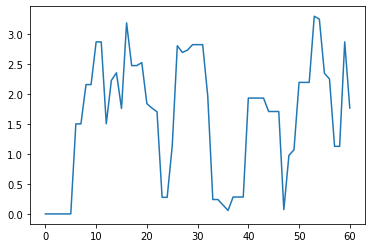

0 rps: 3.1351137633032464


<ipython-input-227-648f2c1cca4b>:53: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)


sessions    14846.00000
revenue     46543.89893
dtype: float64

1 rps: 4.605442895442359


sessions    1865.000
revenue     8589.151
dtype: float64

2 rps: 2.715029008291294


sessions    20021.000000
revenue     54357.595775
dtype: float64

3 rps: 2.5955276275115917


sessions    1294.00000
revenue     3358.61275
dtype: float64

4 rps: 0.8315590710983931


sessions    4543.00000
revenue     3777.77286
dtype: float64

5 rps: 4.028958571428571


sessions     4732.00000
revenue     19065.03196
dtype: float64

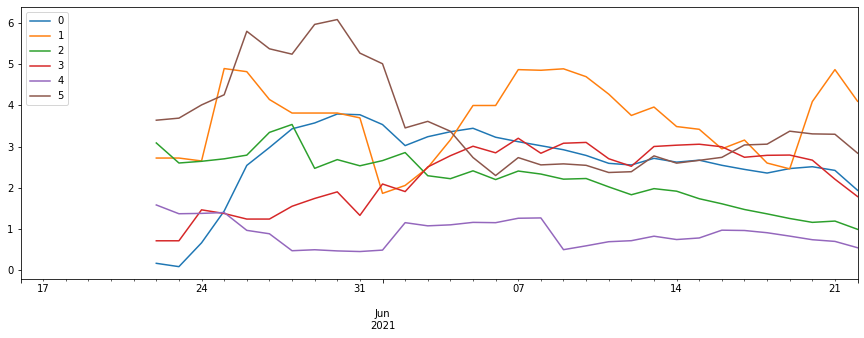

|kpi_df| (24146, 6)


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


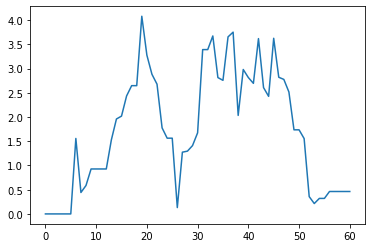

<ipython-input-227-648f2c1cca4b>:53: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)


0 rps: 1.8657036885487197


sessions    10191.00000
revenue     19013.38629
dtype: float64

1 rps: 2.794772588627764


sessions    10042.000000
revenue     28065.106335
dtype: float64

2 rps: 2.997511061128913


sessions     8114.00000
revenue     24321.80475
dtype: float64

3 rps: 2.852645726055613


sessions     7768.000
revenue     22159.352
dtype: float64

4 rps: 3.1489749366467747


sessions    12233.0000
revenue     38521.4104
dtype: float64

5 rps: 3.966530370227536


sessions     5186.0000
revenue     20570.4265
dtype: float64

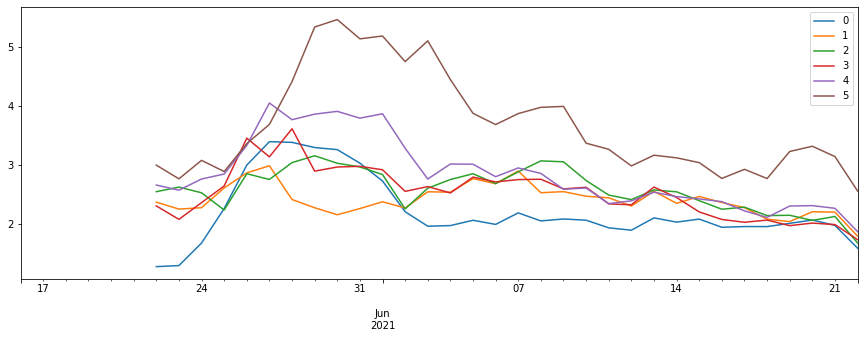

In [229]:
# some discontinued campaigns looks like - makes eval on product of camapgin and keyword difficult
session_df["keyword_clust"] = cluster_on(session_df,start_date,eval_date,end_date,["campaign_id","keyword"],CLUSTS=6)
# session_df["keyword_clust"] = cluster_on(session_df,start_date,eval_date,end_date,["keyword"],CLUSTS=6)

# session_df["demographic_clust"] = cluster_on(session_df,start_date,eval_date,end_date,["age","household_size","etc..."],CLUSTS=6)


session_df["loc_platform_clust"] = cluster_on(session_df,start_date,eval_date,end_date,["dma","operating_system","device"],CLUSTS=6)
session_df["loc_platform_mod"] = session_df.groupby(["loc_platform_clust","utc_dt"])["rps"].transform("mean") / \
                        session_df.groupby("utc_dt")["rps"].transorfm("mean")

ession_df["clust_clust"] = cluster_on(session_df,start_date,eval_date,end_date,["keyword_clust","loc_platform_clust"],CLUSTS=6)

In [230]:
session_df.groupby(["keyword_clust","loc_platform_clust"]).agg({
        "rps": "mean",
        "score": "mean",
        "lps": "mean",
        "rpl": "mean",
        "sessions": "sum",
        "revenue": "sum"
    })

rps     score       lps        rpl  \
keyword_clust loc_platform_clust                                            
0.0           0.0                 2.628107  0.000223  0.211498  12.426169   
              1.0                 2.847460  0.000263  0.212572  13.395250   
              2.0                 3.413228  0.000251  0.239259  14.265832   
              3.0                 3.216120  0.000316  0.241694  13.306560   
              4.0                 3.237292  0.000232  0.236057  13.714025   
              5.0                 4.191280  0.000201  0.244059  17.173258   
1.0           0.0                 2.992705  0.000641  0.218845  13.675000   
              1.0                 4.343982  0.001848  0.256345  16.945832   
              2.0                 5.070717  0.001715  0.299065  16.955208   
              3.0                 4.718282  0.002682  0.323944  14.565130   
              4.0                 5.729261  0.001766  0.303191  18.896509   
              5.0                 4.900337  0.001053  0.258427  18.962174   
2.0           0.0                 1.314508  0.000608  0.116613  11.272356   
              1.0                 2.790836  0.004045  0.199527  13.987248   
              2.0                 2.733054  0.004165  0.199695  13.686135   
              3.0                 2.624340  0.004358  0.215564  12.174303   
              4.0                 2.895778  0.004261  0.199214  14.535988   
              5.0                 4.148489  0.007161  0.285339  14.538799   
3.0           0.0                 1.492602  0.000418  0.222571   6.706197   
              1.0                 2.771958  0.001582  0.272300  10.179776   
              2.0                 2.563587  0.000948  0.216327  11.850542   
              3.0                 2.888407  0.000549  0.197802  14.602500   
              4.0                 3.333087  0.001425  0.315068  10.578928   
              5.0                 3.520095  0.001271  0.258621  13.611033   
4.0           0.0                 0.397816  0.000427  0.055332   7.189611   
              1.0                 0.772345  0.000795  0.061772  12.503245   
              2.0                 1.073955  0.001185  0.074543  14.407208   
              3.0                 0.867092  0.001398  0.071903  12.059250   
              4.0                 1.025880  0.001007  0.084967  12.073815   
              5.0                 1.245791  0.001574  0.102894  12.107531   
5.0           0.0                 3.232237  0.001535  0.237086  13.633179   
              1.0                 3.916172  0.003914  0.258137  15.170911   
              2.0                 3.422289  0.003531  0.256917  13.320600   
              3.0                 4.342396  0.004290  0.291492  14.897120   
              4.0                 4.518700  0.003932  0.252444  17.899780   
              5.0                 4.826456  0.003682  0.301031  16.033089   

                                  sessions       revenue  
keyword_clust loc_platform_clust                          
0.0           0.0                     3305   8685.892180  
              1.0                     2418   6885.158750  
              2.0                     2537   8659.360000  
              3.0                     2408   7744.418000  
              4.0                     3084   9983.810000  
              5.0                     1094   4585.260000  
1.0           0.0                      329    984.600000  
              1.0                      394   1711.529000  
              2.0                      321   1627.700000  
              3.0                      355   1674.990000  
              4.0                      376   2154.202000  
              5.0                       89    436.130000  
2.0           0.0                     3130   4114.410000  
              1.0                     4230  11805.237625  
              2.0                     2624   7171.534750  
              3.0                     2403   6306.288750  
              4.0                     5346  15480.

In [231]:
clust_kpi_df = session_df.groupby(["keyword_clust","loc_platform_clust","utc_dt"]).agg({
        "rps": "mean",
        "score": "mean",
        "lps": "mean",
        "rpl": "mean",
        "sessions": "sum",
        "revenue": "sum"
    })
clust_kpi_df.groupby(["keyword_clust","loc_platform_clust"]) \
    .agg({
        "sessions": "mean",
        "rps": get_wavg_by(clust_kpi_df,"sessions")
    })

sessions       rps
keyword_clust loc_platform_clust                     
0.0           0.0                 40.304878  2.628107
              1.0                 31.402597  2.847460
              2.0                 34.283784  3.413228
              3.0                 32.986301  3.216120
              4.0                 38.550000  3.237292
              5.0                 14.586667  4.191280
1.0           0.0                  6.092593  2.992705
              1.0                  7.035714  4.343982
              2.0                  6.829787  5.070717
              3.0                  7.100000  4.718282
              4.0                  7.372549  5.729261
              5.0                  3.068966  4.900337
2.0           0.0                 37.261905  1.314508
              1.0                 49.186047  2.790836
              2.0                 32.395062  2.733054
              3.0                 29.304878  2.624340
              4.0                 61.448276  2.895778
              5.0                 28.209877  4.148489
3.0           0.0                  4.984375  1.492602
              1.0                  4.018868  2.771958
              2.0                  3.769231  2.563587
              3.0                  3.250000  2.888407
              4.0                  4.132075  3.333087
              5.0                  2.697674  3.520095
4.0           0.0                 11.425287  0.397816
              1.0                  9.862069  0.772345
              2.0                  8.267442  1.073955
              3.0                 10.390805  0.867092
              4.0                  8.693182  1.025880
              5.0                  3.936709  1.245791
5.0           0.0                  8.483146  3.232237
              1.0                 10.482353  3.916172
              2.0                  8.825581  3.422289
              3.0                  8.435294  4.342396
              4.0                 12.931034  4.518700
              5.0                  5.843373  4.826456

# EXAMPLE 2: Cluster aggregated split data

In [8]:
# traffic_source=TABOOLA
traffic_source=MEDIA_ALPHA
rps_df_taboola = agg_rps(
    start_date,end_date,
    product,traffic_source,
    ("traffic_source","campaign_id","dma","operating_system","device","keyword","utc_dt"))
rps_df_taboola = rps_df_taboola.sort_index()
ipydisp(rps_df_taboola[["sessions"]].agg(["max","mean","std"]))

rps_df_taboola["lps"] = rps_df_taboola["num_leads"] / rps_df_taboola["sessions"]
rps_df_taboola["rpl"] = rps_df_taboola["revenue"] / rps_df_taboola["num_leads"]
rps_df_taboola["score"] = rps_df_taboola[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
rps_df_taboola["rps"] = rps_df_taboola["rps_avg"]

INFO:root:query: SELECT traffic_source,campaign_id,dma,operating_system,devic... executed in 6.31 seconds


sessions
max   52.000000
mean   1.493669
std    1.747831

In [75]:
import sklearn.tree
import sklearn.preprocessing
import sklearn.linear_model

Xdf = rps_df_taboola .reset_index()[rps_df_taboola.index.names[:-1]]
ydf = rps_df_taboola["rps"]
wdf = rps_df_taboola["sessions"]

ipydisp(Xdf.isna().sum())

mincnt = 300
for c in Xdf.columns:
    too_few_I = Xdf.groupby(c).transform("count").iloc[:,0] < mincnt
    Xdf.loc[too_few_I,c] = np.NaN

ipydisp(Xdf.isna().sum())

X = sklearn.preprocessing.OneHotEncoder() .fit_transform(Xdf.fillna(""))
y = ydf.fillna(0)
w = wdf

clf = sklearn.tree.DecisionTreeRegressor(min_samples_split=10000).fit(X,y,sample_weight=wdf)

yhat = clf.predict(X)

(y - yhat).abs().mean()

traffic_source         0
campaign_id            7
dma                    0
operating_system       2
device                 0
keyword             4766
dtype: int64

traffic_source          0
campaign_id            76
dma                 15600
operating_system      332
device                  0
keyword              8938
dtype: int64

4.185959041265184

In [76]:
sklearn.tree.export_text(clf)

'|--- feature_73 <= 0.50\n|   |--- feature_5 <= 0.50\n|   |   |--- feature_4 <= 0.50\n|   |   |   |--- feature_65 <= 0.50\n|   |   |   |   |--- feature_6 <= 0.50\n|   |   |   |   |   |--- feature_7 <= 0.50\n|   |   |   |   |   |   |--- feature_62 <= 0.50\n|   |   |   |   |   |   |   |--- feature_67 <= 0.50\n|   |   |   |   |   |   |   |   |--- feature_30 <= 0.50\n|   |   |   |   |   |   |   |   |   |--- feature_54 <= 0.50\n|   |   |   |   |   |   |   |   |   |   |--- value: [2.30]\n|   |   |   |   |   |   |   |   |   |--- feature_54 >  0.50\n|   |   |   |   |   |   |   |   |   |   |--- value: [2.94]\n|   |   |   |   |   |   |   |   |--- feature_30 >  0.50\n|   |   |   |   |   |   |   |   |   |--- value: [3.83]\n|   |   |   |   |   |   |   |--- feature_67 >  0.50\n|   |   |   |   |   |   |   |   |--- value: [2.01]\n|   |   |   |   |   |   |--- feature_62 >  0.50\n|   |   |   |   |   |   |   |--- value: [0.14]\n|   |   |   |   |   |--- feature_7 >  0.50\n|   |   |   |   |   |   |--- valu

[Text(283.2923076923077, 207.55636363636364, 'X[73] <= 0.5\nmse = 58.901\nsamples = 36883\nvalue = 2.834'),
 Text(257.53846153846155, 187.7890909090909, 'X[5] <= 0.5\nmse = 62.014\nsamples = 34003\nvalue = 3.005'),
 Text(231.7846153846154, 168.0218181818182, 'X[4] <= 0.5\nmse = 53.484\nsamples = 25611\nvalue = 2.674'),
 Text(206.03076923076924, 148.25454545454545, 'X[65] <= 0.5\nmse = 48.0\nsamples = 22868\nvalue = 2.561'),
 Text(180.27692307692308, 128.48727272727274, 'X[6] <= 0.5\nmse = 46.881\nsamples = 22502\nvalue = 2.523'),
 Text(154.52307692307693, 108.72, 'X[7] <= 0.5\nmse = 47.808\nsamples = 16976\nvalue = 2.266'),
 Text(128.76923076923077, 88.95272727272729, 'X[62] <= 0.5\nmse = 48.901\nsamples = 15663\nvalue = 2.349'),
 Text(103.01538461538462, 69.18545454545455, 'X[67] <= 0.5\nmse = 49.825\nsamples = 15289\nvalue = 2.397'),
 Text(77.26153846153846, 49.418181818181836, 'X[30] <= 0.5\nmse = 58.637\nsamples = 10654\nvalue = 2.596'),
 Text(51.50769230769231, 29.650909090909096,

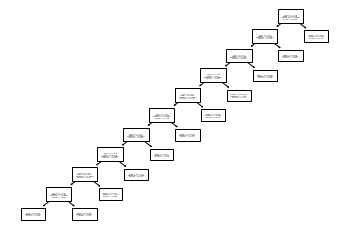

In [77]:
sklearn.tree.plot_tree(clf,fontsize=2)

In [80]:
rps_df_taboola["tree_clust"] = clf.apply(X)

In [ ]:
session_df.groupby([*col,"utc_dt"])[kpis].sum()

|kpi_df| (3045, 6)


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


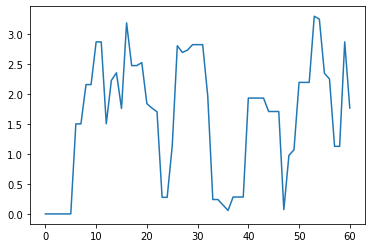

0 rps: 3.1351137633032464


<ipython-input-227-648f2c1cca4b>:53: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)


sessions    14846.00000
revenue     46543.89893
dtype: float64

1 rps: 2.6925225300189592


sessions     9494.0000
revenue     25562.8089
dtype: float64

2 rps: 2.5955276275115917


sessions    1294.00000
revenue     3358.61275
dtype: float64

3 rps: 5.449376043449638


sessions    1519.00000
revenue     8277.60221
dtype: float64

4 rps: 0.8315590710983931


sessions    4543.00000
revenue     3777.77286
dtype: float64

5 rps: 3.0869187840435752


sessions    15605.000000
revenue     48171.367625
dtype: float64

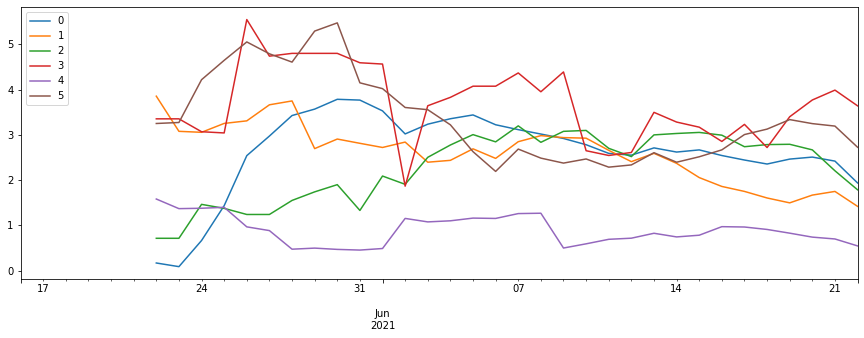

|kpi_df| (24146, 6)


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


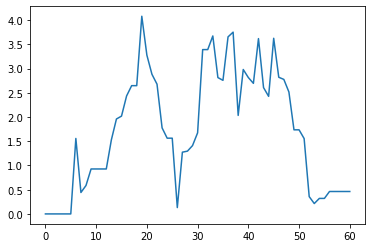

<ipython-input-227-648f2c1cca4b>:53: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)


0 rps: 1.828782471559448


sessions     9933.00000
revenue     18165.29629
dtype: float64

1 rps: 3.147184298467849


sessions     8289.00000
revenue     26087.01065
dtype: float64

2 rps: 2.992595132106792


sessions     7229.00000
revenue     21633.47021
dtype: float64

3 rps: 2.88834458372436


sessions     7459.00000
revenue     21544.16225
dtype: float64

4 rps: 2.9539773436543877


sessions     8171.000000
revenue     24136.948875
dtype: float64

5 rps: 3.29917272946278


sessions    12453.000
revenue     41084.598
dtype: float64

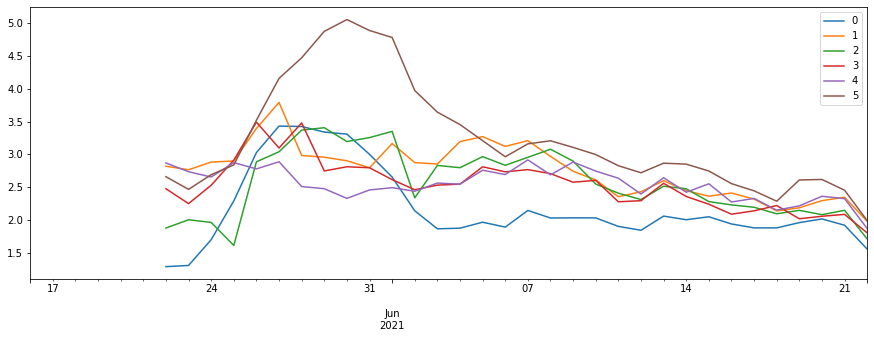

In [237]:
# some discontinued campaigns looks like - makes eval on product of camapgin and keyword difficult
rps_df_taboola["keyword_clust"] = cluster_on(rps_df_taboola,`start_date,eval_date,end_date,["campaign_id","keyword"],CLUSTS=6)
# session_df["keyword_clust"] = cluster_on(session_df,start_date,eval_date,end_date,["keyword"],CLUSTS=6)

rps_df_taboola["loc_platform_clust"] = cluster_on(rps_df_taboola,start_date,eval_date,end_date,["dma","operating_system","device"],CLUSTS=6)

In [238]:
rps_df_taboola.groupby(["keyword_clust","loc_platform_clust"]).agg({
        "rps": "mean",
        "score": "mean",
        "lps": "mean",
        "rpl": "mean",
        "sessions": "sum",
        "revenue": "sum"
    })

rps     score       lps        rpl  \
keyword_clust loc_platform_clust                                            
0.0           0.0                 2.387061  0.000269  0.206439  11.875943   
              1.0                 3.368472  0.000403  0.240630  14.624151   
              2.0                 3.250504  0.000359  0.234020  13.939530   
              3.0                 3.479473  0.000418  0.250286  13.340428   
              4.0                 2.846009  0.000397  0.219282  13.514886   
              5.0                 3.546802  0.000398  0.238190  15.092890   
1.0           0.0                 2.035634  0.000379  0.169854  11.899973   
              1.0                 3.357341  0.001571  0.213690  15.208002   
              2.0                 2.962614  0.001402  0.213839  13.855514   
              3.0                 2.758243  0.001364  0.216772  12.548417   
              4.0                 3.503209  0.001713  0.216676  15.547189   
              5.0                 2.953048  0.001843  0.227148  12.789203   
2.0           0.0                 1.477329  0.000428  0.220217   6.775846   
              1.0                 3.591152  0.001540  0.301587  11.746870   
              2.0                 2.922624  0.001107  0.237028  12.390417   
              3.0                 2.811111  0.000375  0.186160  14.352190   
              4.0                 2.182802  0.002046  0.268095   8.084440   
              5.0                 3.284504  0.001106  0.264184  12.298096   
3.0           0.0                 4.105686  0.003435  0.273936  14.855558   
              1.0                 7.377678  0.009250  0.374830  19.305773   
              2.0                 5.082018  0.005921  0.300254  16.423446   
              3.0                 7.132510  0.008150  0.385635  18.546702   
              4.0                 5.359345  0.006189  0.364151  14.434415   
              5.0                 4.577327  0.005142  0.286404  15.302422   
4.0           0.0                 0.415065  0.000502  0.059055   7.435611   
              1.0                 0.914598  0.001480  0.086689  10.904895   
              2.0                 1.089696  0.001473  0.080435  13.372537   
              3.0                 0.984708  0.001832  0.082426  11.775275   
              4.0                 1.123964  0.001049  0.073724  14.734364   
              5.0                 1.256229  0.001402  0.097581  12.378858   
5.0           0.0                 1.300110  0.001154  0.103587  12.425762   
              1.0                 3.649302  0.008865  0.240240  14.778047   
              2.0                 3.556106  0.007068  0.260686  13.487177   
              3.0                 3.330584  0.007222  0.267113  12.495436   
              4.0                 3.624497  0.008107  0.247786  14.891065   
              5.0                 4.083476  0.010629  0.274199  15.393688   

                                  sessions       revenue  
keyword_clust loc_platform_clust                          
0.0           0.0                     3247   8252.212180  
              1.0                     2237   7487.100000  
              2.0                     2259   7381.880000  
              3.0                     2190   7190.668000  
              4.0                     2233   6812.558750  
              5.0                     2680   9419.480000  
1.0           0.0                     2217   4415.175000  
              1.0                     1308   3994.484400  
              2.0                     1309   3605.050000  
              3.0                     1412   3735.822500  
              4.0                     1455   4442.348000  
              5.0                     1792   5369.929000  
2.0           0.0                      300    445.160000  
              1.0                      158    544.516000  
              2.0                      231    685.098750  
              3.0                      190    524.630000  
              4.0                      198    437.

In [239]:
clust_kpi_df = rps_df_taboola.groupby(["keyword_clust","loc_platform_clust","utc_dt"]).agg({
        "rps": "mean",
        "score": "mean",
        "lps": "mean",
        "rpl": "mean",
        "sessions": "sum",
        "revenue": "sum"
    })
clust_kpi_df.groupby(["keyword_clust","loc_platform_clust"]) \
    .agg({
        "sessions": "mean",
        "rps": get_wavg_by(clust_kpi_df,"sessions")
    })

sessions       rps
keyword_clust loc_platform_clust                     
0.0           0.0                 39.597561  2.409101
              1.0                 28.316456  3.459313
              2.0                 30.120000  3.383472
              3.0                 30.416667  3.453790
              4.0                 30.589041  2.927606
              5.0                 33.500000  3.760431
1.0           0.0                 27.712500  2.031067
              1.0                 17.675676  3.139453
              2.0                 17.000000  2.859275
              3.0                 18.337662  2.679671
              4.0                 19.144737  3.295195
              5.0                 22.123457  2.947050
2.0           0.0                  5.000000  1.529117
              1.0                  3.224490  3.612160
              2.0                  3.786885  2.884903
              3.0                  3.333333  2.793833
              4.0                  3.600000  2.145218
              5.0                  4.018519  3.308135
3.0           0.0                  3.142857  4.212088
              1.0                  4.187500  7.315931
              2.0                  3.904110  5.212772
              3.0                  3.921875  7.153937
              4.0                  4.476923  5.302564
              5.0                  3.766667  4.280229
4.0           0.0                 11.137931  0.421272
              1.0                  7.081395  0.842108
              2.0                  8.522727  1.135341
              3.0                  9.494118  1.127415
              4.0                  7.744186  0.960087
              5.0                  8.528736  1.094393
5.0           0.0                 18.875000  1.260969
              1.0                 32.460674  3.729145
              2.0                 19.385542  3.525690
              3.0                 21.607143  3.309347
              4.0                 28.104651  3.932458
              5.0                 58.550562  4.115101

# Cluster w/ decision tree:

In [125]:
traffic_source=TABOOLA
# traffic_source=MEDIA_ALPHA
rps_df_taboola = agg_rps(
    start_date,end_date,
    product,traffic_source,
    ("traffic_source","campaign_id","dma","operating_system","device","keyword","utc_dt"))
rps_df_taboola = rps_df_taboola.sort_index()
ipydisp(rps_df_taboola[["sessions"]].agg(["max","mean","std"]))

rps_df_taboola["lps"] = rps_df_taboola["num_leads"] / rps_df_taboola["sessions"]
rps_df_taboola["rpl"] = rps_df_taboola["revenue"] / rps_df_taboola["num_leads"]
rps_df_taboola["score"] = rps_df_taboola[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
rps_df_taboola["rps"] = rps_df_taboola["rps_avg"]

INFO:root:query: SELECT traffic_source,campaign_id,dma,operating_system,devic... executed in 7.63 seconds


sessions
max   83.000000
mean   1.822568
std    2.810563

In [140]:
import sklearn.tree
import sklearn.preprocessing
import sklearn.linear_model

Xdf = rps_df_taboola .reset_index()[rps_df_taboola.index.names[:-1]]
ydf = rps_df_taboola["rps"]
wdf = rps_df_taboola["sessions"]

ipydisp(Xdf.isna().sum())

mincnt = 100
for c in Xdf.columns:
    too_few_I = Xdf.groupby(c).transform("count").iloc[:,0] < mincnt
    Xdf.loc[too_few_I,c] = np.NaN

ipydisp(Xdf.isna().sum())

X = sklearn.preprocessing.OneHotEncoder() .fit_transform(Xdf.fillna(""))
y = ydf.fillna(0)
w = wdf

clf = sklearn.tree.DecisionTreeRegressor(min_samples_leaf=1000).fit(X,y,sample_weight=wdf)

yhat = clf.predict(X)
print("Tree RPS MAE:",(y - yhat).abs().mean())

rps_df_taboola["tree_clust"] = clf.apply(X)

traffic_source       0
campaign_id         23
dma                  0
operating_system     1
device               0
keyword             21
dtype: int64

traffic_source          0
campaign_id           557
dma                  4227
operating_system       20
device                  0
keyword             11553
dtype: int64

Tree RPS MAE: 0.6991902550827274


In [141]:
print(sklearn.tree.export_text(clf))

|--- feature_205 <= 0.50
|   |--- feature_185 <= 0.50
|   |   |--- feature_184 <= 0.50
|   |   |   |--- feature_190 <= 0.50
|   |   |   |   |--- value: [0.15]
|   |   |   |--- feature_190 >  0.50
|   |   |   |   |--- feature_182 <= 0.50
|   |   |   |   |   |--- value: [0.10]
|   |   |   |   |--- feature_182 >  0.50
|   |   |   |   |   |--- value: [0.15]
|   |   |--- feature_184 >  0.50
|   |   |   |--- feature_192 <= 0.50
|   |   |   |   |--- value: [0.21]
|   |   |   |--- feature_192 >  0.50
|   |   |   |   |--- value: [0.31]
|   |--- feature_185 >  0.50
|   |   |--- feature_23 <= 0.50
|   |   |   |--- feature_3 <= 0.50
|   |   |   |   |--- feature_12 <= 0.50
|   |   |   |   |   |--- feature_206 <= 0.50
|   |   |   |   |   |   |--- feature_37 <= 0.50
|   |   |   |   |   |   |   |--- feature_35 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_203 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_26 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_192 <= 0.50
|   

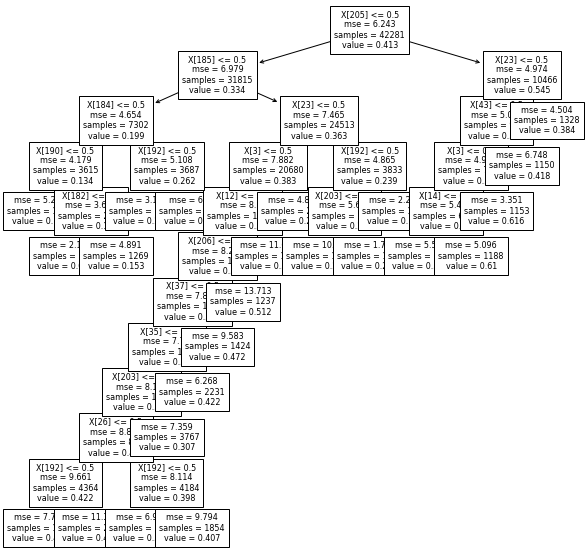

In [144]:
plt.figure(figsize=(10,10))
sklearn.tree.plot_tree(clf,fontsize=8)
plt.show()

In [133]:
rps_df_taboola.groupby(["tree_clust"]).agg({
        "rps": "mean",
        "score": "mean",
        "lps": "mean",
        "rpl": "mean",
        "sessions": "sum",
        "revenue": "sum"
    })

rps     score       lps        rpl  sessions      revenue
tree_clust                                                                
4           0.171330  0.000070  0.014136  11.486421      1484   218.242000
6           0.075627  0.000121  0.010229   9.351055      1236   121.563710
7           0.150015  0.000151  0.016417   9.112892      1433   218.709420
9           0.214919  0.000237  0.025757   8.061618      1920   395.019260
10          0.293742  0.000295  0.019724  15.071858      2349   723.449200
20          0.449613  0.000459  0.048725   9.076721      2227   953.055670
21          0.370357  0.000355  0.028836  13.379350      2601  1083.727310
23          0.416439  0.000666  0.044460   9.230197      3204  1255.306795
24          0.391426  0.000526  0.039248  10.407006      2223   905.409490
25          0.395006  0.000777  0.035165  10.804563      8682  2664.688745
26          0.390348  0.000773  0.025776  16.259178      5805  2450.503150
27          0.525743  0.000844  0.042732  11.284059      2054   969.060000
28          0.532210  0.000773  0.045517  11.170983      1724   882.507650
29          0.564742  0.000000  0.047886  12.031186      1233   709.840000
30          0.245353  0.000421  0.018229  14.680174      4639  1285.430000
33          0.308120  0.000387  0.025507  11.710556      1930   573.817250
34          0.211278  0.000625  0.023627   8.851282      2396   540.111950
35          0.174560  0.000209  0.027803   6.130861      1231   214.580150
40          0.473479  0.000461  0.046921  11.203421     12540  6741.653650
41          0.561209  0.000000  0.039918  12.970584      5721  3487.519810
42          0.481869  0.001866  0.036102  15.679064      5781  3558.694840
43          0.401646  0.000357  0.039145  10.553137      1598   668.634510
44          0.343862  0.000929  0.033322  11.642612      3049  1171.347500

In [134]:
clust_kpi_df = rps_df_taboola.groupby(["tree_clust","utc_dt"]).agg({
        "rps": "mean",
        "score": "mean",
        "lps": "mean",
        "rpl": "mean",
        "sessions": "sum",
        "revenue": "sum"
    })
clust_kpi_df.groupby(["tree_clust"]) \
    .agg({
        "sessions": "mean",
        "rps": get_wavg_by(clust_kpi_df,"sessions")
    })

sessions       rps
tree_clust                      
4            18.097561  0.168223
6            23.320755  0.079578
7            28.098039  0.146053
9            26.666667  0.210179
10           36.138462  0.283941
20           31.814286  0.456183
21           35.630137  0.368650
23          168.631579  0.420620
24          111.150000  0.394747
25          114.236842  0.326504
26          241.875000  0.350708
27           60.411765  0.498282
28           49.257143  0.486763
29           88.071429  0.558646
30          171.814815  0.219354
33           77.200000  0.299679
34          114.095238  0.221878
35           58.619048  0.177036
40          165.000000  0.460197
41          381.400000  0.545751
42          251.347826  0.671684
43           25.774194  0.416136
44          138.590909  0.346535

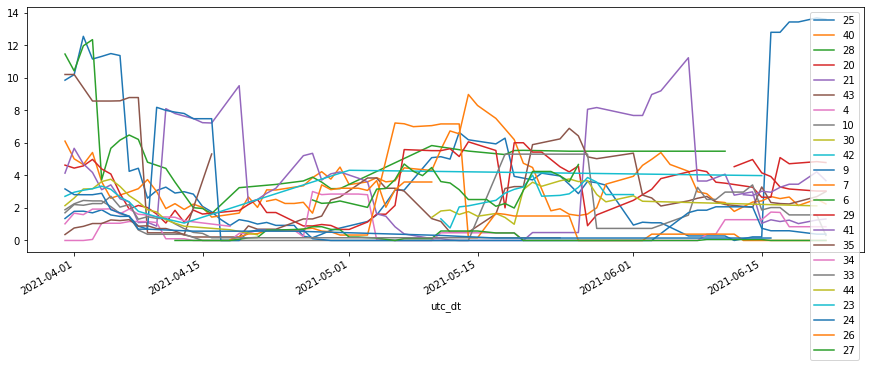

In [135]:
for ti in rps_df_taboola["tree_clust"].drop_duplicates():
    rps_df_taboola \
        .loc[rps_df_taboola["tree_clust"] == ti] \
        .groupby("utc_dt") \
        .apply(lambda df: wavg(df["rps"],df["sessions"])) \
        .fillna(0).rolling(7).sum() \
        .plot(label=ti,figsize=(15,5))
plt.legend()
plt.show()

# Cluster w/ decision tree:

In [146]:
rps_df_taboola = agg_rps(
    start_date,end_date,
    product,tuple(MAJOR_TRAFFIC_SOURCES),
    ("traffic_source","campaign_id","dma","operating_system","device","keyword","utc_dt"))
rps_df_taboola = rps_df_taboola.sort_index()
ipydisp(rps_df_taboola[["sessions"]].agg(["max","mean","std"]))

rps_df_taboola["lps"] = rps_df_taboola["num_leads"] / rps_df_taboola["sessions"]
rps_df_taboola["rpl"] = rps_df_taboola["revenue"] / rps_df_taboola["num_leads"]
rps_df_taboola["score"] = rps_df_taboola[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
rps_df_taboola["rps"] = rps_df_taboola["rps_avg"]

INFO:root:query: SELECT traffic_source,campaign_id,dma,operating_system,devic... executed in 41.77 seconds


session uniqueness assummption not satisfied


sessions
max   83.000000
mean   1.246929
std    1.138609

In [147]:
import sklearn.tree
import sklearn.preprocessing
import sklearn.linear_model

Xdf = rps_df_taboola .reset_index()[rps_df_taboola.index.names[:-1]]
ydf = rps_df_taboola["rps"]
wdf = rps_df_taboola["sessions"]

ipydisp(Xdf.isna().sum())

mincnt = 100
for c in Xdf.columns:
    too_few_I = Xdf.groupby(c).transform("count").iloc[:,0] < mincnt
    Xdf.loc[too_few_I,c] = np.NaN

ipydisp(Xdf.isna().sum())

X = sklearn.preprocessing.OneHotEncoder() .fit_transform(Xdf.fillna(""))
y = ydf.fillna(0)
w = wdf

clf = sklearn.tree.DecisionTreeRegressor(min_samples_leaf=3000).fit(X,y,sample_weight=wdf)

yhat = clf.predict(X)
print("Tree RPS MAE:",(y - yhat).abs().mean())

rps_df_taboola["tree_clust"] = clf.apply(X)

traffic_source         0
campaign_id         1001
dma                    0
operating_system      41
device                 0
keyword             5660
dtype: int64

traffic_source          0
campaign_id          3814
dma                    89
operating_system      155
device                  0
keyword             48879
dtype: int64

Tree RPS MAE: 3.654696152974085


In [148]:
print(sklearn.tree.export_text(clf))

|--- feature_4 <= 0.50
|   |--- feature_353 <= 0.50
|   |   |--- feature_0 <= 0.50
|   |   |   |--- feature_48 <= 0.50
|   |   |   |   |--- feature_355 <= 0.50
|   |   |   |   |   |--- feature_103 <= 0.50
|   |   |   |   |   |   |--- feature_3 <= 0.50
|   |   |   |   |   |   |   |--- feature_323 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_715 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_42 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_96 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |   |--- feature_96 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.80]
|   |   |   |   |   |   |   |   |   |--- feature_42 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_352 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.23]
|   |   |   |   |   |   |   |   |   |   |--- feature_352 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: 

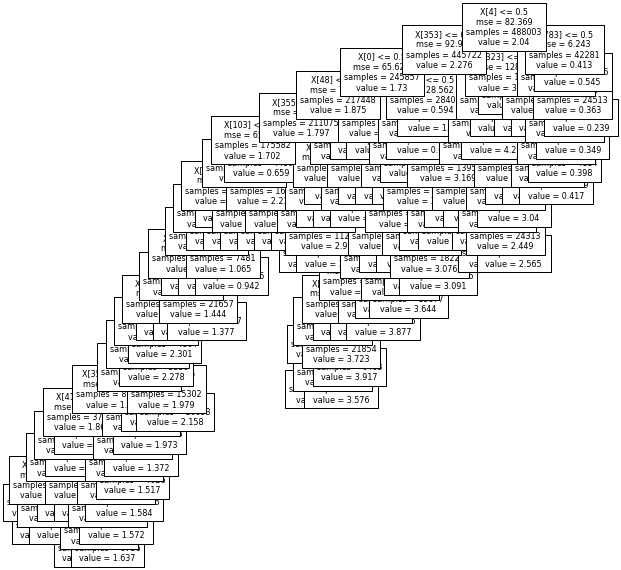

In [149]:
plt.figure(figsize=(10,10))
sklearn.tree.plot_tree(clf,fontsize=8)
plt.show()

In [150]:
rps_df_taboola.groupby(["tree_clust"]).agg({
        "rps": "mean",
        "score": "mean",
        "lps": "mean",
        "rpl": "mean",
        "sessions": "sum",
        "revenue": "sum"
    })

rps     score       lps        rpl  sessions       revenue
tree_clust                                                                 
21          1.411271  0.001431  0.123079  11.470234      4301   5943.521010
23          1.825879  0.002201  0.070424  25.703624      4159   7525.590210
24          1.846143  0.002327  0.071793  25.763915      9207  16633.922470
26          2.090272  0.002252  0.118067  17.666613      3936   8009.560730
27          1.904681  0.002110  0.104189  17.933397      7886  14576.602130
...              ...       ...       ...        ...       ...           ...
152         0.385519  0.000284  0.029598  13.353226      4007   1669.153310
153         0.405355  0.000604  0.042151   9.689311      5427   2160.716285
154         0.389819  0.000776  0.030264  13.110583     19311   6733.575895
155         0.239303  0.000409  0.025593   9.163016      5557   1328.509350
156         0.460022  0.000612  0.042354  12.249039     28689  15627.850310

[79 rows x 6 columns]

In [151]:
clust_kpi_df = rps_df_taboola.groupby(["tree_clust","utc_dt"]).agg({
        "rps": "mean",
        "score": "mean",
        "lps": "mean",
        "rpl": "mean",
        "sessions": "sum",
        "revenue": "sum"
    })
clust_kpi_df.groupby(["tree_clust"]) \
    .agg({
        "sessions": "mean",
        "rps": get_wavg_by(clust_kpi_df,"sessions")
    })

sessions       rps
tree_clust                      
21           48.325843  1.413311
23           52.645570  1.823470
24          113.666667  1.850302
26           54.666667  2.085271
27          109.527778  1.929304
...                ...       ...
152          53.426667  0.384894
153         217.080000  0.408460
154         232.662651  0.347022
155         213.730769  0.232229
156         363.151899  0.459864

[79 rows x 2 columns]

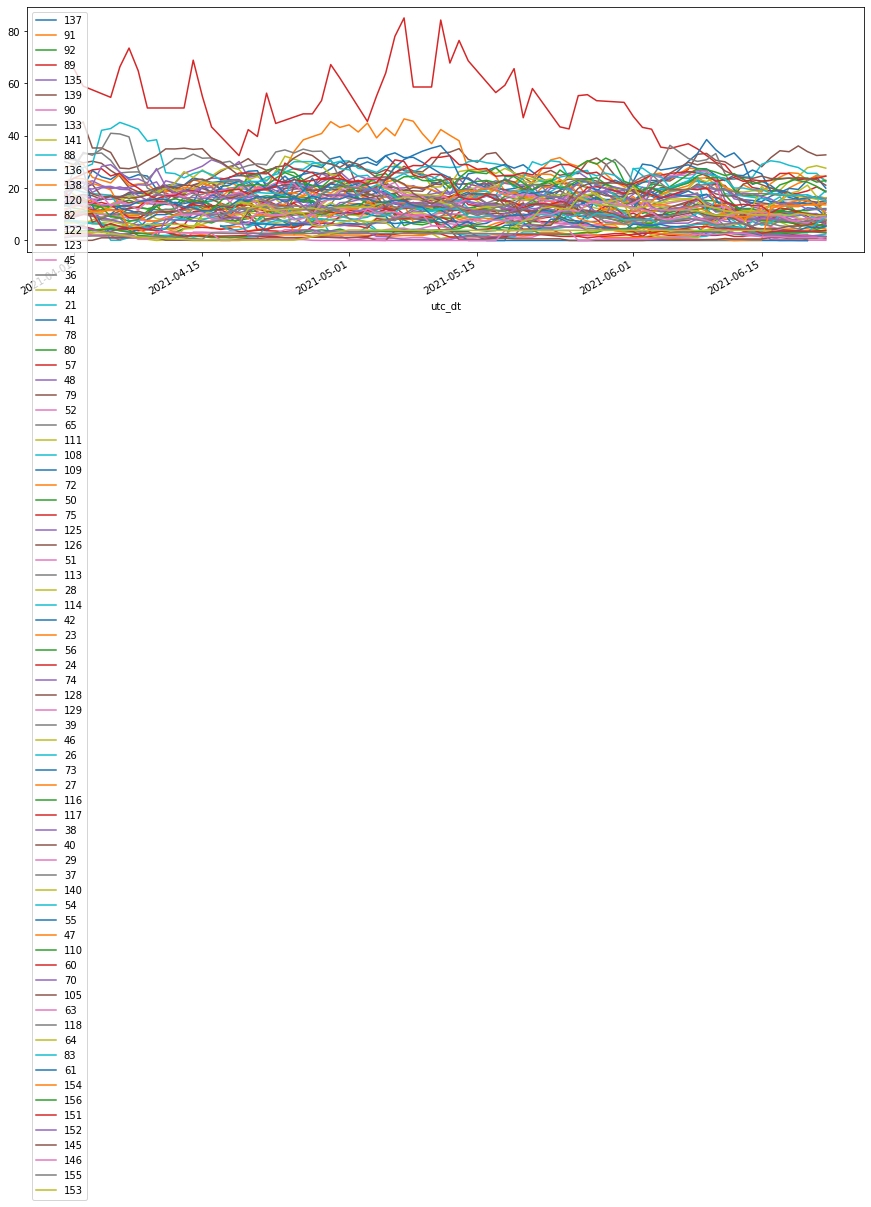

In [152]:
for ti in rps_df_taboola["tree_clust"].drop_duplicates():
    rps_df_taboola \
        .loc[rps_df_taboola["tree_clust"] == ti] \
        .groupby("utc_dt") \
        .apply(lambda df: wavg(df["rps"],df["sessions"])) \
        .fillna(0).rolling(7).sum() \
        .plot(label=ti,figsize=(15,5))
plt.legend()
plt.show()

### 2021-06-23: @aduriset @jdelvalle
- want to measure correlation/dependence of categorical split vars w/ cont rps
    - cat,cat metrics w/ binned rps
        chi
    - cont,cont metrcs w/ 1 hot encoded split vars
    - cat,cont metrics
- correlation metrics
    - MI:
        - sklearn.feature_selection.mi_regression
        - would need AFAICT to rresample input arrays
    - ANOVA:
        - scipy.stats.f_oneway
    - pt biserial
        - needs binary vars tho
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
        - https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1


- approaches I tried
1. rank splits by their correlation/covaraince/MI w/ `agg_rps`
    - tried ANOVA,pt.biserial,MI - had most success w/ MI
    - was dificult to compute b/c couldnt find methods that accepted sample weight
    - MI approach was promising but didnt go down that route
2. rank splits by intra-split agg_rps variance
    - had most success w/ this
    - tested out an approahc where I cluster the split on rps - had good results
    - think this is the mtd to use going forward
    TODO:
    - test fitting on general traffic sources?
    - test clustering on multiple days of rps data - 
        or rolling rps data or something
    - try out more granular aggs
    - is there some kind of metric which measures total variance
        and computes how much of that variance is captured by a split?

3. fit decision tree on rps data 
    - MSE criterion is apparently the same as minimizng inter split variance
    - computationally intensive
    - not 100% clear how to go from tree to campaign structure
    
    

- overall goal:
    - specific ROI targetting w/ minimal campaigns
- what this means for accnt structure
    - for many variables we must split campaigns to target ROI
    - want to capture greatest amt of rps variation w/ 
        fewest # of campaigns
- 2 ways of approaching this
    1. minimize rps variation w/in a campaign
        - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
        - tried this out a little - but the computation was intensive which made it slow going
    2. maximize rps variation outside campaigns
        - mostly focused on this approach


In [ ]:
# wstd(rps_clust_df["rps_avg"], rps_clust_df["sessions"])

### Some other things I tried:
- 

- naive cross producct b/w all split variables
    - too granular at cluster time to accurately measure rps to assign cluster - spent rest of sprint trying to compensate
- finding correlation b/w split variables to figure out which had the least covariance and thus benefited least from cross product
    - think my method of computing covariance wasnt great - or perhaps covariance issnt the appropriate metric
    - found that when all traffic sources were lumped together - covaraicne was dominated by the inherent covariance w/in categorical variables
    - found that when only taboola was considered  there was no clear difference in covaraince
- finding a relationship b/c bucket size at cluster time and eventual MAE
    - didnt really pan out - did not find much of a 
- 1-hot encoding cluster variables and computing 1-day and 7-day rps at different rollup levels (e.g. traffic source level, <traffic_source,campaign> level , <traffic_source,campaign,location> level , etc....) - combining all into a vector and esimtating rps via ML model
    - has added advantage of being able to forcast rps per bucket by shifting vectors
    - just have no idea how to evaluate this method
- consitent challenge was evaluating methods - tried to simulate covaraince and more realistic variable distribution - but in the end just thought I was forcing the result via the evaluation method

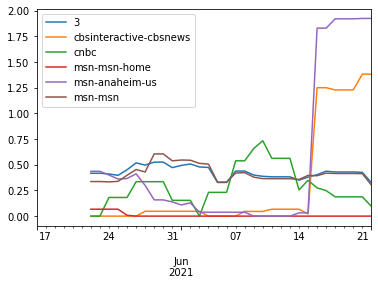

In [88]:
clust_kpi_df \
        .groupby("utc_dt")["rps"] \
        .agg(get_wavg_by(clust_kpi_df,"sessions")) \
        .reindex(pd.date_range(eval_date-7*DAY,end_date)) \
        .fillna(0).rolling(7).mean() \
        .plot(label=ci)
large_uvals = clust_kpi_df.groupby(kpi_df.index.names[:-1])["sessions"].sum().sort_values().index[-5:]
for uval in large_uvals:
    kpi_df \
        .loc[uval,"rps"] \
        .reindex(pd.date_range(eval_date-7*DAY,end_date)) \
        .fillna(0).rolling(7).mean() \
        .plot(label=uval)
plt.legend()
plt.show()

INFO:root:query: SELECT traffic_source,random_normal_split_8,random_normal_sp... executed in 29.54 seconds
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


sessions
max   22.000000
mean   1.709604
std    1.454465

INFO:root:query: SELECT traffic_source,campaign_id,dma,operating_system,devic... executed in 34.66 seconds


session uniqueness assummption not satisfied


sessions
max   83.000000
mean   1.242384
std    1.119836

sessions          608942.0
num_leads          70306.0
score_null_cnt     23878.0
score_adv_cnt       7586.0
score_supp_cnt      7589.0
score_cnt          31464.0
dtype: float64

6it [00:26,  4.46s/it]


rps_avg  \
traffic_source random_normal_split_8 random_normal_split_16 random_normal_split_32 random_normal_split_64 utc_dt                
BING           1                     4                      14                     34                     2021-05-10      0.0   
                                     5                      14                     34                     2021-04-20      0.0   
                                                            16                     32                     2021-06-05      0.0   
                                     6                      15                     33                     2021-06-02      0.0   
                                                            18                     30                     2021-05-24      0.0   

                                                                                                                      rpl  \
traffic_source random_normal_split_8 random_normal_split_16 random_normal_split_32 random_normal_split_64 utc_dt            
BING           1                     4                      14                     34                     2021-05-10  NaN   
                                     5                      14                     34                     2021-04-20  NaN   
                                                            16                     32                     2021-06-05  NaN   
                                     6                      15                     33                     2021-06-02  NaN   
                                                            18                     30                     2021-05-24  NaN   

                                                                                                                      rps_avg_true  \
traffic_source random_normal_split_8 random_normal_split_16 random_normal_split_32 random_normal_split_64 utc_dt                     
BING           1                     4                      14                     34                     2021-05-10      2.441071   
                                     5                      14                     34                     2021-04-20      2.745783   
                                                            16                     32                     2021-06-05      1.395143   
                                     6                      15                     33                     2021-06-02      2.290649   
                                                            18                     30                     2021-05-24      1.739522   

                                                                                                                          push  
traffic_source random_normal_split_8 random_normal_split_16 random_normal_split_32 random_normal_split_64 utc_dt                
BING           1                     4                      14                     34                     2021-05-10  2.000957  
                                     5                      14                     34                     2021-04-20  2.289902  
                                                            16                     32                     2021-06-05  2.244308  
                                     6                      15                     33                     2021-06-02  0.996631  
                                                            18                     30                     2021-05-24  0.852009

rps_avg  \
traffic_source random_normal_split_8 random_normal_split_16 random_normal_split_32 random_normal_split_64 utc_dt                
BING           1                     4                      14                     34                     2021-05-10      0.0   
                                     5                      14                     34                     2021-04-20      0.0   
                                                            16                     32                     2021-06-05      0.0   
                                     6                      15                     33                     2021-06-02      0.0   
                                                            18                     30                     2021-05-24      0.0   

                                                                                                                      rpl  \
traffic_source random_normal_split_8 random_normal_split_16 random_normal_split_32 random_normal_split_64 utc_dt            
BING           1                     4                      14                     34                     2021-05-10  NaN   
                                     5                      14                     34                     2021-04-20  NaN   
                                                            16                     32                     2021-06-05  NaN   
                                     6                      15                     33                     2021-06-02  NaN   
                                                            18                     30                     2021-05-24  NaN   

                                                                                                                      rps_avg_true  \
traffic_source random_normal_split_8 random_normal_split_16 random_normal_split_32 random_normal_split_64 utc_dt                     
BING           1                     4                      14                     34                     2021-05-10      4.884478   
                                     5                      14                     34                     2021-04-20      6.287575   
                                                            16                     32                     2021-06-05      3.131131   
                                     6                      15                     33                     2021-06-02      2.282932   
                                                            18                     30                     2021-05-24      1.482088   

                                                                                                                          push  
traffic_source random_normal_split_8 random_normal_split_16 random_normal_split_32 random_normal_split_64 utc_dt                
BING           1                     4                      14                     34                     2021-05-10  2.000957  
                                     5                      14                     34                     2021-04-20  2.289902  
                                                            16                     32                     2021-06-05  2.244308  
                                     6                      15                     33                     2021-06-02  0.996631  
                                                            18                     30                     2021-05-24  0.852009

rps_avg_        190.000000
rps_avg         641.737123
rpl             805.526729
rps_avg_true     40.861327
push             11.390502
dtype: float64

sessions               1.000000
revenue              190.000000
num_leads              1.000000
lps_avg                1.000000
rpl_avg              190.000000
rps_                 190.000000
rps_avg              428.703908
rps_std                     NaN
rps_var                     NaN
score_null_cnt         1.000000
score_null_avg         0.065400
score_adv_cnt               NaN
score_adv_avg               NaN
score_supp_cnt              NaN
score_supp_avg              NaN
score_cnt              1.000000
int_ix            187787.000000
rps_avg_raw          190.000000
lps                    1.000000
rpl                  428.703908
rps_avg_true           5.793077
push                   2.256336
rps_avg_             190.000000
Name: (GOOGLE, 3, 10, 17, 27, 2021-04-05 00:00:00), dtype: float64

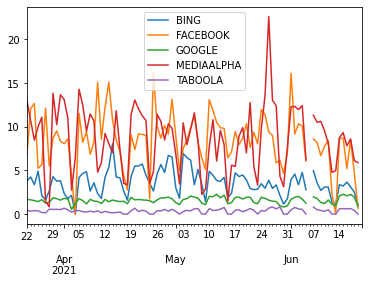

{'MAE': 2.838104959495233, 'MSE': 96.95212296559384}

In [3]:
# rps_df = agg_rps_taboola(
#     start_date,end_date,
#     product,traffic_source,
#     ("utc_dt",*campaign_split_fields[BEST_SPLIT]))
rps_df = agg_rps(
    start_date,end_date,
    product,tuple(MAJOR_TRAFFIC_SOURCES),
    ("traffic_source",
     "random_normal_split_8","random_normal_split_16",
     "random_normal_split_32","random_normal_split_64",
     "utc_dt"))
ipydisp(rps_df[["sessions"]].agg(["max","mean","std"]))

rps_df_taboola = agg_rps(
    start_date,end_date,
    product,tuple(MAJOR_TRAFFIC_SOURCES),
    ("traffic_source","campaign_id","dma","operating_system","device","keyword","utc_dt"))
rps_df_taboola = rps_df_taboola.sort_index()
ipydisp(rps_df_taboola[["sessions"]].agg(["max","mean","std"]))

# splitI = rps_df.reset_index(level=-1).index.unique()
# dtI = pd.date_range(start_date,end_date)
# rps_df = rps_df.reindex(
#     pd.MultiIndex.from_tuples(
#         ((*i,dti) for i,dti in itertools.product(splitI,dtI)),
#         names=rps_df.index.names
#     ),

# )

ipydisp(rps_df[[
    "sessions",
    "num_leads",
    "score_null_cnt",
    "score_adv_cnt",
    "score_supp_cnt",
    "score_cnt"
]].sum())

rps_df["rps_avg_raw"] = rps_df["rps_avg"]

rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]

rps_df["rps_avg_true"] = rps_df \
    .groupby([*rps_df.index.names[:1],"utc_dt"])["rps_avg"] \
    .transform(get_wavg_by(rps_df,"sessions"))

rps_df["push"] = 1

# simulate a change in monetization at 1/4 way thru eval period
dtI = pd.date_range(start_date,end_date)
mid_date = eval_date + (end_date - eval_date) / 4 
rps_step = pd.Series(np.ones(len(dtI)),index=dtI)
rps_step.index.name = "utc_dt"
rps_step[mid_date:] = 2
rps_df["push"] *= rps_step

np.random.seed(0)
# simulate variance of randomized split variables
for i in [8,16,32,64]:
    push = 0.5 + 1*np.random.rand(i)
    split_push = pd.Series(data=push,index=range(i))
    split_push.index.name = f"random_normal_split_{i}"
    rps_df["push"] *= split_push
    
# simulate covariance of randomized split variables
import tqdm
for i,j in tqdm.tqdm(itertools.combinations([8,16,32,64],2)):
    push = 0.75 + 0.5*np.random.rand(i*j)
    split_push = pd.Series(data=push,index=pd.MultiIndex.from_product([range(i),range(j)]))
    split_push.index.names = [f"random_normal_split_{i}",f"random_normal_split_{j}"]
    split_push.name = "split_push"
    rps_df["push"] *= rps_df[[]].join(split_push,how="left")["split_push"]

rps_df["rps_avg_"] = rps_df["rps_avg"]
ipydisp(rps_df[["rps_avg","rpl","rps_avg_true","push"]].head())
rps_df[["rps_avg","rpl","rps_avg_true"]] *= rps_df["push"].values.reshape(-1,1)
ipydisp(rps_df[["rps_avg","rpl","rps_avg_true","push"]].head())

ipydisp(rps_df[["rps_avg_","rps_avg","rpl","rps_avg_true","push"]].max())
ipydisp(rps_df.loc[rps_df.idxmax()["rps_avg_"]])

underlying_source_rps = rps_df \
    .groupby(["traffic_source","utc_dt"]) \
    ["rps_avg_raw"].agg(get_wavg_by(rps_df,"sessions"))
sample_buckets = rps_df \
    .reset_index()[rps_df.index.names[:-1]] \
    .drop_duplicates("traffic_source") \
    .iterrows()
for _,bucket in sample_buckets:
    bucket_i = tuple(bucket.values)
    bucket_rps_df = rps_df.loc[bucket_i].reindex(pd.date_range(start_date,end_date))
    bucket_rps_df["rps_avg_true"] = underlying_source_rps.loc[bucket_i[0]] * bucket_rps_df["push"].min()
    bucket_rps_df["rps_avg_true"].plot(label=bucket_i[0])
plt.legend()
plt.show()

delt = rps_df["rps_avg"] - rps_df["rps_avg_true"]
d = {
    "MAE": wavg(delt.abs(),rps_df["sessions"]),
    "MSE": wavg(delt ** 2,rps_df["sessions"]),
}
d

In [4]:
# # requires `gnuplot` which may not be available on gh action server
# import termplotlib
# termplotlib.plot.plot(bucket_rps_df["rps_avg_true"].fillna(0),bucket_rps_df["rps_avg_true"].index)

In [5]:
# import plotext
# plotext.plot(bucket_rps_df["rps_avg_true"].fillna(0),bucket_rps_df.index)
# plotext.show()

In [6]:
# import uniplot
# uniplot.plot([bucket_rps_df["rps_avg_true"].fillna(0),bucket_rps_df["rps_avg"].fillna(0)],
#             bucket_rps_df.index,
#              legend_labels=["rps_avg_true","rps_avg"])

### 2021-06-18 Rethink:
Seems like the relation b/w bucket size at cluster time and MAE might not be clear or possible to capture via simulation.  How about this: we find which variables have observable covariance and cluster w/in their cross product.  This needs to be carried out on real data.  

#### Unresolved question: What about clustering w/in individual variables first?

In [7]:
split_M = rps_df_taboola.reset_index()[rps_df_taboola.index.names[:-1]].fillna("")

import sklearn.preprocessing
split_enc_1hot = sklearn.preprocessing.OneHotEncoder().fit(split_M)

split_M_1hot = split_enc_1hot.transform(split_M)

C1hot = split_enc_1hot.get_feature_names().reshape(-1)
multiindex_1hot = pd.MultiIndex.from_tuples(
    (th,"_".join(tt)) for th,*tt in (c.split("_") for c in C1hot))
multiindex_1hot
N = rps_df_taboola.__len__()
split_coli_M = split_M_1hot.T @ split_M_1hot / N
split_coli_df = pd.DataFrame(split_coli_M.todense(),columns=multiindex_1hot,index=multiindex_1hot)

Exy = split_coli_df
Ex = np.diag(split_coli_df)

split_cov_df = Exy - Ex.reshape(-1,1) * Ex.reshape(1,-1)

split_cov_df.abs().sum(axis=0,level=0).sum(axis=1,level=0)

x0        x1        x2        x3        x4        x5
x0  1.277596  1.276610  0.141767  0.261704  0.240327  1.155605
x1  1.276610  1.883243  0.463203  0.382892  0.298942  1.693349
x2  0.141767  0.463203  1.972994  0.138745  0.100681  0.512308
x3  0.261704  0.382892  0.138745  1.544637  1.033933  0.480689
x4  0.240327  0.298942  0.100681  1.033933  1.142991  0.431587
x5  1.155605  1.693349  0.512308  0.480689  0.431587  1.973836

In [19]:
split_M = rps_df_taboola.reset_index()[rps_df_taboola.index.names[:-1]].fillna("")

import sklearn.preprocessing
split_enc_1hot = sklearn.preprocessing.OneHotEncoder().fit(split_M)

split_M_1hot = split_enc_1hot.transform(split_M)

bucket_rps = rps_df_taboola["rps_avg"]
split_rps = split_M_1hot.multiply(bucket_rps.abs().values.reshape(-1,1) ** 0.5)

C1hot = split_enc_1hot.get_feature_names().reshape(-1)
multiindex_1hot = pd.MultiIndex.from_tuples(
    (th,"_".join(tt)) for th,*tt in (c.split("_") for c in C1hot))
N = rps_df_taboola.__len__()
split_corps_M = split_rps.T @ split_rps / N

split_corps_df = pd.DataFrame(split_corps_M.todense(),columns=multiindex_1hot,index=multiindex_1hot)

Exy = split_corps_df
Ex = np.diag(split_corps_df)

split_rps_cov_df = Exy - Ex.reshape(-1,1) * Ex.reshape(1,-1)

cat_split_imp_df = split_rps_cov_df.abs().sum(axis=0,level=0).sum(axis=1,level=0)
cat_split_imp_df.columns = rps_df_taboola.index.names[:-1]
cat_split_imp_df.index = rps_df_taboola.index.names[:-1]
cat_split_imp_df

traffic_source  campaign_id       dma  operating_system  \
traffic_source          3.669462     3.669434  2.489923          2.491664   
campaign_id             3.669434     6.102635  2.933507          2.530730   
dma                     2.489923     2.933507  6.642815          2.487993   
operating_system        2.491664     2.530730  2.487993          4.392816   
device                  2.474755     2.488429  2.476681          2.954404   
keyword                 3.546831     5.268019  3.683962          2.660354   

                    device   keyword  
traffic_source    2.474755  3.546831  
campaign_id       2.488429  5.268019  
dma               2.476681  3.683962  
operating_system  2.954404  2.660354  
device            3.210658  2.540731  
keyword           2.540731  6.648479

In [20]:
split_M = rps_df_taboola.loc[[TABOOLA]].reset_index()[rps_df_taboola.index.names[:-1]].fillna("")

import sklearn.preprocessing
split_enc_1hot = sklearn.preprocessing.OneHotEncoder().fit(split_M)

split_M_1hot = split_enc_1hot.transform(split_M)
bucket_rps = rps_df_taboola.loc[[TABOOLA],"rps_avg"]
split_rps = split_M_1hot.multiply(bucket_rps.abs().values.reshape(-1,1) ** 0.5)

C1hot = split_enc_1hot.get_feature_names().reshape(-1)
multiindex_1hot = pd.MultiIndex.from_tuples(
    (th,"_".join(tt)) for th,*tt in (c.split("_") for c in C1hot))
N = rps_df_taboola.loc[[TABOOLA]].__len__()
split_corps_M = split_rps.T @ split_rps / N

split_corps_df = pd.DataFrame(split_corps_M.todense(),columns=multiindex_1hot,index=multiindex_1hot)

Exy = split_corps_df
Ex = np.diag(split_corps_df)

split_rps_cov_df = Exy - Ex.reshape(-1,1) * Ex.reshape(1,-1)

cat_split_imp_df = split_rps_cov_df.abs().sum(axis=0,level=0).sum(axis=1,level=0)
cat_split_imp_df.columns = rps_df_taboola.index.names[:-1]
cat_split_imp_df.index = rps_df_taboola.index.names[:-1]
cat_split_imp_df

traffic_source  campaign_id       dma  operating_system  \
traffic_source          0.232787     0.232787  0.232787          0.232787   
campaign_id             0.232787     0.486665  0.367219          0.268676   
dma                     0.232787     0.367219  0.501998          0.250855   
operating_system        0.232787     0.268676  0.250855          0.285127   
device                  0.232787     0.242799  0.237577          0.243446   
keyword                 0.232787     0.374439  0.359140          0.264106   

                    device   keyword  
traffic_source    0.232787  0.232787  
campaign_id       0.242799  0.374439  
dma               0.237577  0.359140  
operating_system  0.243446  0.264106  
device            0.245441  0.243409  
keyword           0.243409  0.468412

### OK - scores used to be unlabeled always until 2021-05-10 - going to just add labeled scores together

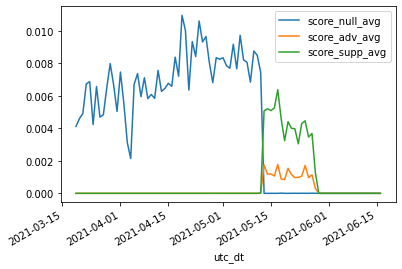

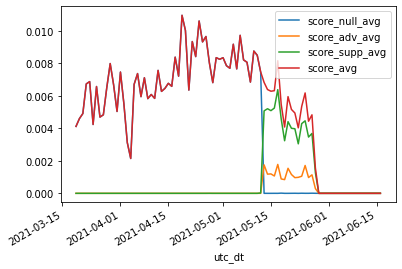

In [35]:
from matplotlib import pyplot as plt

rps_df.groupby("utc_dt")[["score_null_avg","score_adv_avg","score_supp_avg"]] \
    .agg(get_wavg_by(rps_df,"sessions")) \
    .plot()
plt.show()

rps_df["score_avg"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
rps_df.groupby("utc_dt")[["score_null_avg","score_adv_avg","score_supp_avg","score_avg"]] \
    .agg(get_wavg_by(rps_df,"sessions")) \
    .plot()
plt.show()

## Clustering
### TODO
- time decay in clustering data
- cluster using time series dot product in distance matrix - would need to apply gaussian or some other filter b/c of data sparisty issues
- eval whether multi dimensional clustering is better than clustering on rps only 

### 2021-06-16
- ok - bascially this is the problem - when targetting a lot of variables the buckets get so small that we cant accurately fit clusters to these small buckets even when using all available data
- but - we want to cluster buckets so that we can use small time windows to estimate rps
- so what u might do is collapse your split to a subset of split variables and cluster on those variables - then separately compute modifiers on the collapsed variables
- you could even then repeat the process on the collapsed variables - so you are somehow picking different split variables to cluster the cross product of
- so what I am trying to do here is get an idea of how this process might work

#### Idea 1:
- ok - basically clustering wont work if there are insufficient samples over entire history to estimate metric (rps,lps,etc....)
- for each traffic source `rps_avg_raw` is the same for all buckets in that traffic source - so we can just keep lumping in buckets and measuring MSE of bucket group `rps_avg_raw` mean w/ known underying `rps_avg_raw`
- this can let us know how many sessions per bucket are required to get a good idea of 
- this will bias us to 
- after we cluster we can then measure the MSE of each clusters mean `rps_avg_raw`

#### Idea 2:
- larger buckets at cluster step makes clustering more precise - but it might mean we are "misclassifying" sub-buckets
- we should observe that this will make our estimation of simulated `rps_avg` for those sub buckets less accurate
- kindof like a variance/bias tradeoff
- so there is some kind of tradeoff precision and accuracy w/ bucket size at cluster step
- we can vary bucket size by trying all 2ples and 3ples of split vars as grouping - and see what maximizes simulated `rps_avg` estimation


In [37]:
fitI = rps_df.reset_index(level="utc_dt",drop=False)["utc_dt"].dt.date < eval_date
fitI.index = rps_df.index
clustC = ["rps_avg","rpl","lps","score_avg","score_null_avg","score_adv_avg","score_supp_avg"]


In [38]:
for N in [
        *[[nm] for nm in rps_df.index.names[1:-1]],
        *itertools.combinations(rps_df.index.names[1:-1],2),
        *itertools.combinations(rps_df.index.names[1:-1],3)
        ]:
    mean_sess_per_day = rps_df \
        .groupby(["traffic_source",*N])["sessions"].sum().mean()
    bucket_rps = \
        (rps_df[fitI]["rps_avg_raw"] * rps_df[fitI]["sessions"].values) \
            .groupby(["traffic_source",*N]) .sum() / \
        rps_df[fitI]["sessions"] \
            .groupby(["traffic_source",*N]) .sum()
    print(N,mean_sess_per_day,bucket_rps.mean(),bucket_rps.std())

['random_normal_split_8'] 20171.333333333332 2.5498287004872617 3.417542693028503
['random_normal_split_16'] 11865.490196078432 1.8627457552471347 1.4809345008771766
['random_normal_split_32'] 5991.485148514851 1.8456408748354631 1.8033796350981293
['random_normal_split_64'] 3087.4489795918366 2.2940100440136786 5.270504171336876
('random_normal_split_8', 'random_normal_split_16') 2500.5785123966944 2.089489091252741 4.62481612397322
('random_normal_split_8', 'random_normal_split_32') 1384.7597254004577 2.027158440549312 4.119460846860407
('random_normal_split_8', 'random_normal_split_64') 745.2463054187192 2.3300035373536017 6.230704767517468
('random_normal_split_16', 'random_normal_split_32') 796.2368421052631 1.9525352353614416 3.2203993466735783
('random_normal_split_16', 'random_normal_split_64') 430.398293029872 1.883243070603593 3.986467518629144
('random_normal_split_32', 'random_normal_split_64') 239.18577075098815 2.0753655862293727 5.060655622025825
('random_normal_split_8'

In [39]:
D = []
for N in [
        *[[nm] for nm in rps_df.index.names[1:-1]],
        *itertools.combinations(rps_df.index.names[1:-1],2),
        *itertools.combinations(rps_df.index.names[1:-1],3)
        ]:
    
    rps_fit_df = rps_df[fitI]
    bucket_rev = (rps_fit_df["rps_avg"] * rps_fit_df["sessions"].values) \
                    .groupby(["traffic_source",*N]) .sum()
    bucket_sessions = rps_fit_df["sessions"] \
                        .groupby(["traffic_source",*N]) .sum()
    bucket_df = pd.DataFrame([bucket_rev,bucket_sessions,bucket_rev/bucket_sessions],
                             index=["revenue","sessions","rps_avg"]).T

    import sklearn.cluster
    CLUSTS = 8

    # quantile_enc = sklearn.preprocessing.KBinsDiscretizer(n_bins=CLUSTS,encode="ordinal") .fit(bucket_df[["rps_avg"]])
    # bucket_df["rps_quantile_i"] = quantile_enc.transform(bucket_df[["rps_avg"]])

    clust = sklearn.cluster.KMeans(n_clusters=min(CLUSTS,len(bucket_df))) \
        .fit(bucket_df[["rps_avg"]],sample_weight=bucket_df["sessions"])
    bucket_df["rps_cluster_i"] = clust.predict(bucket_df[["rps_avg"]])
    # clust = sklearn.cluster.KMeans(n_clusters=CLUSTS) .fit(bucket_rps[clustC],sample_weight=bucket_rps["sessions"])
    # bucket_rps["rps_cluster_i"] = clust.predict(bucket_rps[clustC])

    rps_df["rps_cluster_i"] = 1
    df = rps_df["rps_cluster_i"] * bucket_df["rps_cluster_i"]
    rps_df["rps_cluster_i"] = df.reset_index().set_index(rps_df.index.names)
    rps_df["rps_cluster_i"] = rps_df["rps_cluster_i"].fillna(-1)
    print("|rps_df|",rps_df.shape)

    rps_df["sessions_cluster"] = rps_df.groupby(["rps_cluster_i","utc_dt"])["sessions"].transform(sum)
    rps_df["rps_cluster"] = rps_df.groupby(["rps_cluster_i","utc_dt"]) \
        ["rps_avg"].transform(get_wavg_by(rps_df,"sessions"))

    delt = rps_df["rps_cluster"] - rps_df["rps_avg_true"] 
    d = {
        "subsplit": N,
        "mean_bucket_sesisons": bucket_df["sessions"].mean(),
        "mean_daily_cluster_sessions": rps_df["sessions_cluster"].mean(),
        "MAE": wavg(delt.abs(),rps_df["sessions"]),
        "MSE": wavg(delt ** 2,rps_df["sessions"]),
    }
    pprint.pprint(d)
    D.append(d)

pd.DataFrame(D)

|rps_df| (354540, 25)
{'MAE': 1.0770118967641262,
 'MSE': 3.334305770174016,
 'mean_bucket_sesisons': 13170.933333333332,
 'mean_daily_cluster_sessions': 1964.634898742032,
 'subsplit': ['random_normal_split_8']}
|rps_df| (354540, 27)
{'MAE': 0.7846733065978088,
 'MSE': 1.9193748926796823,
 'mean_bucket_sesisons': 7747.607843137255,
 'mean_daily_cluster_sessions': 2197.888909572968,
 'subsplit': ['random_normal_split_16']}
|rps_df| (354540, 27)
{'MAE': 1.0851745640156074,
 'MSE': 3.324219705580166,
 'mean_bucket_sesisons': 3991.191919191919,
 'mean_daily_cluster_sessions': 1493.3717549500761,
 'subsplit': ['random_normal_split_32']}
|rps_df| (354540, 27)
{'MAE': 1.0789606518903652,
 'MSE': 3.354070636177114,
 'mean_bucket_sesisons': 2079.621052631579,
 'mean_daily_cluster_sessions': 1967.0132961019913,
 'subsplit': ['random_normal_split_64']}
|rps_df| (354540, 27)
{'MAE': 0.7603587331818028,
 'MSE': 1.9916600947954464,
 'mean_bucket_sesisons': 1733.017543859649,
 'mean_daily_cluster_se

subsplit  mean_bucket_sesisons  \
0                             [random_normal_split_8]          13170.933333   
1                            [random_normal_split_16]           7747.607843   
2                            [random_normal_split_32]           3991.191919   
3                            [random_normal_split_64]           2079.621053   
4     (random_normal_split_8, random_normal_split_16)           1733.017544   
5     (random_normal_split_8, random_normal_split_32)            963.726829   
6     (random_normal_split_8, random_normal_split_64)            518.540682   
7    (random_normal_split_16, random_normal_split_32)            549.552156   
8    (random_normal_split_16, random_normal_split_64)            297.984917   
9    (random_normal_split_32, random_normal_split_64)            166.580101   
10  (random_normal_split_8, random_normal_split_16...            168.713920   
11  (random_normal_split_8, random_normal_split_16...             95.303425   
12  (random_normal_split_8, random_normal_split_32...             55.108508   
13  (random_normal_split_16, random_normal_split_3...             33.928216   

    mean_daily_cluster_sessions       MAE       MSE  
0                   1964.634899  1.077012  3.334306  
1                   2197.888910  0.784673  1.919375  
2                   1493.371755  1.085175  3.324220  
3                   1967.013296  1.078961  3.354071  
4                   1910.907500  0.760359  1.991660  
5                   1607.214523  1.076874  3.308517  
6                   2330.521030  1.084882  3.495896  
7                   2353.796102  0.755510  2.090842  
8                   2871.672172  0.809842  2.710488  
9                   2680.549929  1.111947  3.835444  
10                  2757.446136  0.795741  2.544426  
11                  4023.356792  0.885684  3.414692  
12                  2802.849382  1.163285  4.412064  
13                  3534.763694  0.987858  4.729122

In [ ]:
pd.DataFrame(D).plot.scatter(x="mean_bucket_sesisons",y="MAE",)

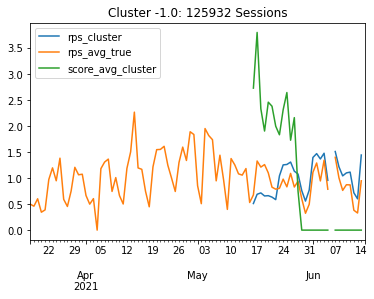

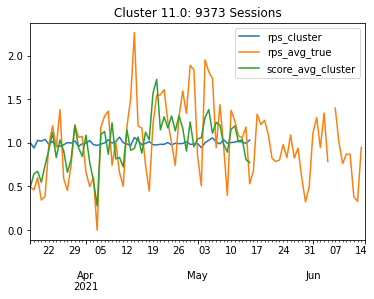

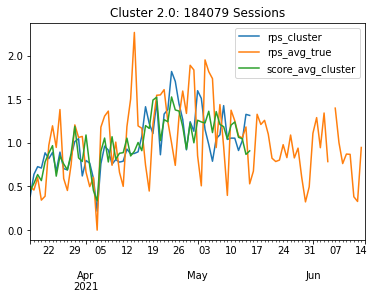

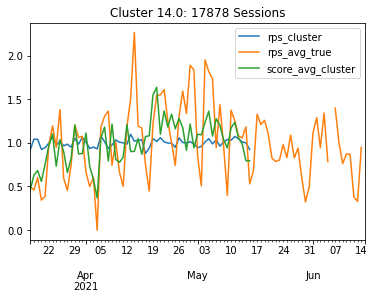

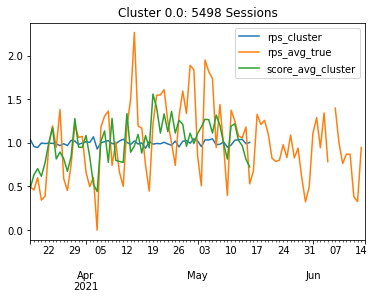

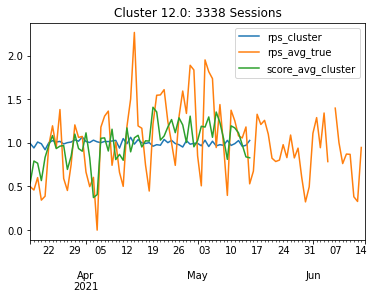

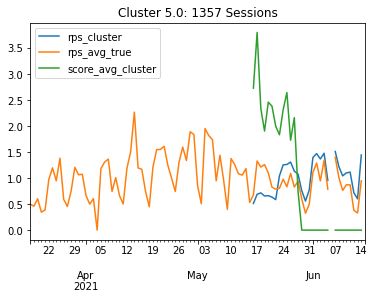

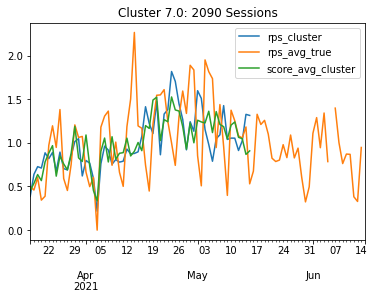

In [342]:
clust_df = rps_df \
    .groupby("rps_cluster_i") \
    .agg({
        "sessions": "",
        "rps_cluster": get_wavg_by(rps_df,"sessions"),
    })
for cluster_i in rps_df["rps_cluster_i"].drop_duplicates():
    clust_sessions = clust_session_cnt.loc[cluster_i,"sessions"]
    if clust_sessions < 1000: continue
    sample_bucket = rps_df \
        [rps_df["rps_cluster_i"] == cluster_i] \
        .reset_index()[rps_df.index.names].iloc[0,:-1]
    bucket_i = tuple(sample_bucket.values)
    bucket_rps_df = rps_df.loc[bucket_i].reindex(pd.date_range(start_date,end_date))

    bucket_rps_df["rps_avg_true"] = bucket_rps_df["push"].min() * rps_df \
        .groupby(["traffic_source","utc_dt"]) \
        ["rps_avg_raw"].agg(get_wavg_by(rps_df,"sessions")) \
        .loc[bucket_i[0]]

    bucket_rps_df[["rps_cluster","score_avg_cluster"]] = rps_df \
        .groupby(["rps_cluster_i","utc_dt"]) \
        [["rps_cluster","score_avg_cluster"]].agg(get_wavg_by(rps_df,"sessions")) \
        .loc[bucket_rps_df["rps_cluster_i"].min()]
    (bucket_rps_df / bucket_rps_df.mean())[["rps_cluster","rps_avg_true","score_avg_cluster"]].plot()
    plt.title(f"Cluster {cluster_i}: {clust_sessions} Daily")
    plt.show()


In [344]:
delt = rps_df["rps_cluster"] - rps_df["rps_avg_true"]
d = {
    "MAE": wavg(delt.abs(),rps_df["sessions"]),
    "MSE": wavg(delt ** 2,rps_df["sessions"]),
}
d

{'MAE': 1.8591230995489791, 'MSE': 24.216564046446763}

In [218]:
fitI = rps_df.reset_index(level="utc_dt",drop=False)["utc_dt"].dt.date < eval_date
fitI.index = rps_df.index
clustC = ["rps_avg","rpl","lps","score_avg","score_null_avg","score_adv_avg","score_supp_avg"]

bucket_rps = rps_df \
    [fitI] \
    .groupby(level=[rps_df.index.names[:3]]) \
    .apply(lambda df: wavg(df[clustC],df["sessions"]))
bucket_rps["sessions"] = rps_df[fitI].groupby(level=[rps_df.index.names[:3]])["sessions"].sum()

import sklearn.preprocessing
import sklearn.cluster
CLUSTS = 16

quantile_enc = sklearn.preprocessing.KBinsDiscretizer(n_bins=CLUSTS,encode="ordinal") .fit(bucket_rps[["rps_avg"]])
bucket_rps["rps_quantile_i"] = quantile_enc.transform(bucket_rps[["rps_avg"]])

clust = sklearn.cluster.KMeans(n_clusters=CLUSTS) .fit(bucket_rps[["rps_avg"]],sample_weight=bucket_rps["sessions"])
bucket_rps["rps_cluster_i"] = clust.predict(bucket_rps[["rps_avg"]])
# clust = sklearn.cluster.KMeans(n_clusters=CLUSTS) .fit(bucket_rps[clustC],sample_weight=bucket_rps["sessions"])
# bucket_rps["rps_cluster_i"] = clust.predict(bucket_rps[clustC])

rps_df[["rps_quantile_i","rps_cluster_i"]] = 1
df = rps_df[["rps_quantile_i","rps_cluster_i"]] * bucket_rps[["rps_quantile_i","rps_cluster_i"]]
rps_df[["rps_quantile_i","rps_cluster_i"]] = df.reset_index().set_index(rps_df.index.names)
rps_df[["rps_quantile_i","rps_cluster_i"]] = rps_df[["rps_quantile_i","rps_cluster_i"]].fillna(-1)
print("|rps_df|",rps_df.shape)

rps_df["sessions_quantile"] = rps_df \
    .groupby(["rps_quantile_i","utc_dt"]) \
    ["sessions"].transform(sum)
rps_df[["rps_quantile","rpl_quantile","lps_quantile","score_avg_quantile",
        "score_null_avg_quantile","score_adv_avg_quantile","score_supp_avg_quantile"]] = \
    rps_df \
        .groupby(["rps_quantile_i","utc_dt"]) \
        [["rps_avg","rpl","lps","score_avg",
          "score_null_avg","score_adv_avg","score_supp_avg"]] \
        .transform(get_wavg_by(rps_df,"sessions"))
ipydisp(rps_df[["rps_quantile"]].drop_duplicates())

rps_df["sessions_cluster"] = rps_df \
    .groupby(["rps_cluster_i","utc_dt"]) \
    ["sessions"].transform(sum)
rps_df[["rps_cluster","rpl_cluster","lps_cluster","score_avg_cluster",
        "score_null_avg_cluster","score_adv_avg_cluster","score_supp_avg_cluster"]] = \
    rps_df \
        .groupby(["rps_cluster_i","utc_dt"]) \
        [["rps_avg","rpl","lps","score_avg",
          "score_null_avg","score_adv_avg","score_supp_avg"]] \
        .transform(get_wavg_by(rps_df,"sessions"))
ipydisp(rps_df[["rps_cluster"]].drop_duplicates())

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


|rps_df| (352201, 42)


rps_quantile
traffic_source random_normal_split_8 random_normal_split_16 random_normal_split_32 random_normal_split_64 utc_dt                  
BING           1                     6                      16                     32                     2021-05-17      0.000000
                                     7                      19                     31                     2021-03-30      0.178581
                                     8                      17                     35                     2021-03-24      0.296145
                                                            19                     28                     2021-05-11      0.268846
               2                     3                      16                     39                     2021-04-07      3.514964
...                                                                                                                            ...
TABOOLA        2                     9                      16                     31                     2021-04-14      0.067221
                                                                                   37                     2021-05-03      0.055704
                                                            17                     33                     2021-05-13      1.044536
               3                     6                      12                     31                     2021-05-22      0.721716
                                     7                      14                     28                     2021-05-29      1.085606

[1061 rows x 1 columns]

rps_cluster
traffic_source random_normal_split_8 random_normal_split_16 random_normal_split_32 random_normal_split_64 utc_dt                 
BING           1                     6                      16                     32                     2021-05-17     0.000000
                                     7                      13                     38                     2021-05-26     0.739161
                                                            14                     29                     2021-05-25     0.320821
                                                            19                     31                     2021-03-30     0.260347
                                     8                      17                     35                     2021-03-24     0.161093
...                                                                                                                           ...
MEDIAALPHA     6                     5                      13                     28                     2021-04-23    21.827482
TABOOLA        1                     8                      13                     29                     2021-03-20     0.098039
               2                     6                      11                     25                     2021-03-25     0.157945
                                                            12                     33                     2021-04-04     0.142666
                                                            13                     34                     2021-03-17     0.062779

[1005 rows x 1 columns]

## Qualitatively - cluster level RPS  more useful than cluster level lead score

In [237]:
quantile_rps_df = rps_df \
    .groupby(["rps_quantile_i","utc_dt"]) \
    .agg({
        "sessions": sum,
        "rps_quantile": get_wavg_by(rps_df,"sessions"),
        "score_avg_quantile": get_wavg_by(rps_df,"sessions")
    })
largest_quantile_i = quantile_rps_df["sessions"].mean(level="rps_quantile_i").idxmax()
quantile_rps_df \
    .groupby("rps_quantile_i") \
    .agg({
        "sessions": "mean",
        "rps_quantile": get_wavg_by(quantile_rps_df,"sessions"),
        "score_avg_quantile": get_wavg_by(quantile_rps_df,"sessions"),
    })

sessions  rps_quantile  score_avg_quantile
rps_quantile_i                                               
-1.0               1.466667      0.123974            0.000000
 0.0              10.258824      0.917170            0.000396
 1.0             664.863636      0.236695            0.000707
 2.0             267.252874      0.684345            0.000503
 3.0            1190.887640      0.945489            0.006209
 4.0            1424.168539      1.227111            0.006353
 5.0            1191.101124      1.463617            0.009345
 6.0             327.123596      2.085474            0.003325
 7.0             396.460674      2.284220            0.005140
 8.0             158.483146      2.819104            0.002955
 9.0             258.516854      3.491512            0.002815
 10.0            546.292135      4.190527            0.004879
 11.0            279.202247      5.100002            0.006950
 12.0             64.292135      6.902445            0.003379

In [238]:
cluster_rps_df = rps_df \
    .groupby(["rps_cluster_i","utc_dt"]) \
    .agg({
        "sessions": sum,
        "rps_cluster": get_wavg_by(rps_df,"sessions"),
        "score_avg_cluster": get_wavg_by(rps_df,"sessions")
    })
largest_cluster_i = cluster_rps_df["sessions"].mean(level="rps_cluster_i").idxmax()
cluster_rps_df \
    .groupby("rps_cluster_i") \
    .agg({
        "sessions": "mean",
        "rps_cluster": get_wavg_by(cluster_rps_df,"sessions"),
        "score_avg_cluster": get_wavg_by(cluster_rps_df,"sessions"),
    })

sessions  rps_cluster  score_avg_cluster
rps_cluster_i                                             
-1.0              1.466667     0.123974           0.000000
 0.0            690.910112     0.265812           0.000694
 1.0              1.000000    21.827482           0.020800
 2.0            266.584270     5.066704           0.007139
 3.0             75.797753     3.554836           0.001982
 4.0              3.452055     8.083758           0.003418
 5.0              1.000000    15.576261           0.023200
 6.0           1694.988764     1.040174           0.007254
 7.0             73.707865     6.650746           0.003278
 8.0              1.083333     8.284444           0.009215
 9.0            262.382022     3.539276           0.002869
 10.0             1.133333    10.966157           0.005553
 11.0           517.191011     4.207937           0.004995
 12.0           182.280899     2.915474           0.002865
 13.0          1835.078652     1.423657           0.007845
 14.0           502.752809     0.766018           0.001941
 15.0           660.089888     2.024757           0.004551

In [241]:
I = (rps_df["rps_cluster_i"] == largest_cluster_i) & \
    (rps_df["rps_quantile_i"] == largest_quantile_i)

0.09777655372926256

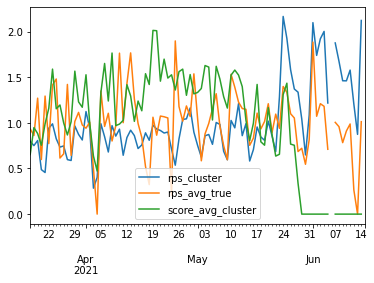

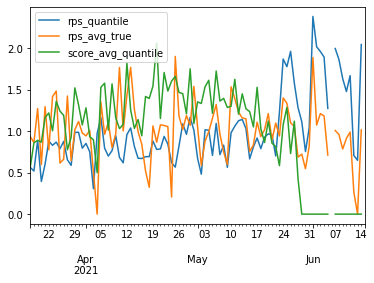

In [242]:
sample_bucket = rps_df[I].reset_index()[rps_df.index.names].iloc[0,:-1]
bucket_i = tuple(sample_bucket.values)
bucket_rps_df = rps_df.loc[bucket_i].reindex(pd.date_range(start_date,end_date))

bucket_rps_df["rps_avg_true"] = bucket_rps_df["push"].min() * rps_df \
    .groupby(["traffic_source","utc_dt"]) \
    ["rps_avg_raw"].agg(get_wavg_by(rps_df,"sessions")) \
    .loc[bucket_i[0]]

bucket_rps_df[["rps_cluster","score_avg_cluster"]] = rps_df \
    .groupby(["rps_cluster_i","utc_dt"]) \
    [["rps_cluster","score_avg_cluster"]].agg(get_wavg_by(rps_df,"sessions")) \
    .loc[bucket_rps_df["rps_cluster_i"].min()]
bucket_rps_df[["rps_quantile","score_avg_quantile"]] = rps_df \
    .groupby(["rps_quantile_i","utc_dt"]) \
    [["rps_quantile","score_avg_quantile"]].agg(get_wavg_by(rps_df,"sessions")) \
    .loc[bucket_rps_df["rps_quantile_i"].min()]

(bucket_rps_df / bucket_rps_df.mean())[["rps_cluster","rps_avg_true","score_avg_cluster"]].plot()
plt.show()

(bucket_rps_df / bucket_rps_df.mean())[["rps_quantile","rps_avg_true","score_avg_quantile"]].plot()
plt.show()

## Eval all methods:

In [36]:
def get_eval(df,f):
    if callable(f):
        return f(df)
    elif isinstance(f,str):
        return df[f]
    else:
        raise Exception("Asdfafdsaf")
def set_eval(df,f):
    if callable(f):
        df[f.__name__] = f(df)
        return f.__name__
    else:
        return f
def mult(df,x,y):
    x = get_eval(df,x)
    y = get_eval(df,y)
    globals()["mult.x"] = x
    globals()["mult.y"] = y
    return x * y
def get_mult(x,y):
    def f(df):
        return mult(df,x,y)
    xnm = x.__name__ if callable(x) else x
    ynm = y.__name__ if callable(y) else y
    f.__name__ = f"mult({xnm},{ynm})"
    return f 

def cma(df,c,w):
    c = set_eval(df,c)
    return df \
        .groupby(rps_df.index.names[:-1]) \
        .apply(lambda df: df[[c]]
                   .fillna(method="ffill")
                   .rolling(w).mean()) \
        [c]
    # TODO: fix
#     if window == 1:
#             delta = (rps_df[f"{RPS_COL}_1dcma"] - rps_df[RPS_COL]).abs().fillna(0)
#             assert all(delta < 1e-4)
def get_cma(c,w):
    def f(df):
        return cma(df,c,w)
    cnm = c.__name__ if callable(c) else c
    f.__name__ = f"cma({cnm},{w})"
    return f
def rps_rpl_lpc(df):
    rpl_dt = df.groupby("utc_dt")["rpl"].transform(get_wavg_by(df,"sessions"))
    return rpl_dt * df["lps"]
def rpl_dt_parameterized(df,c):
    return df.groupby("utc_dt")[c].transform(get_wavg_by(df,"sessions"))
def rpl_dt(df):
    return rpl_dt_parameterized(df,"rpl")
def rpl_quantile_dt(df):
    return rpl_dt_parameterized(df,"rpl_quantile")
def rpl_cluster_dt(df):
    return rpl_dt_parameterized(df,"rpl_cluster")
import sklearn.linear_model
def regress_lps(df):
    X = df[["score_avg"]]
    w = df["sessions"]
    y = df["lps"]
    X = X.fillna(X.mean())
    w = w.fillna(0)
    y = y.fillna(y.mean())
    reg = sklearn.linear_model.LinearRegression().fit(X[fitI],y[fitI],sample_weight=w[fitI])
    return reg.predict(X)
def regress_lps_cluster(df):
    X = df[["score_avg_cluster"]]
    w = df["sessions"]
    y = df["lps_cluster"]
    X = X.fillna(X.mean())
    w = w.fillna(0)
    y = y.fillna(y.mean())
    reg = sklearn.linear_model.LinearRegression().fit(X[fitI],y[fitI],sample_weight=w[fitI])
    return reg.predict(X)
    
rps_est_mtds = [
    *[get_cma(c,w) 
      for c in ["rps_avg","rps_quantile","rps_cluster"]
      for w in [1,7,14,30]],
    rps_rpl_lpc,get_mult(rpl_dt,"lps"),
    *[get_mult(rpl_dt,get_cma("lps",lps_win)) for lps_win in (7,14,30)],
#     [get_mult(get_cma(rpl_dt,rpl_win),get_cma("lps",lps_win)) 
#      for rpl_win in (7,14) for lps_win in (7,14,30)] + \
    *[get_mult(rpl_dt,lpsf)
      for lpsf in ("lps","lps_quantile","lps_cluster",regress_lps,regress_lps_cluster)],
    *[get_mult(rpl_dt,get_cma(lpsf,14))
      for lpsf in ("lps","lps_quantile","lps_cluster",regress_lps,regress_lps_cluster)],
]

D = []
for RPS_COL in rps_est_mtds:
    RPS_COL = set_eval(rps_df,RPS_COL)
    for i in rps_df.index.unique(0):
        evalI = ~fitI
        eval_df = rps_df[evalI].loc[i]
        delt = eval_df[RPS_COL] - eval_df[f"rps_avg_true"]
        d = {
            "rps_col": RPS_COL,
            "underlying_bucket": i,
            "sessions": eval_df["sessions"].sum(),
            "MAE": wavg(delt.abs(),eval_df["sessions"]),
            "MRE": wavg(delt.abs() / (eval_df[f"rps_avg_true"].abs() + 1e-10),eval_df["sessions"]),
            "MSE": wavg(delt ** 2,eval_df["sessions"]),
        }
        D.append(d)

perfdf = pd.DataFrame(D)

method_perfdf = perfdf.groupby(["rps_col"]).agg({
    "MAE": get_wavg_by(perfdf,"sessions"),
    "MSE": get_wavg_by(perfdf,"sessions"),
    "MRE": get_wavg_by(perfdf,"sessions"),
}).sort_values(by="MSE")

method_perfdf.sort_values(by="MAE").round(2)

MAE    MSE         MRE
rps_col                                                          
cma(rps_cluster,1)                        0.71   1.30  4972327.38
cma(rps_quantile,1)                       0.72   1.13  8053107.80
mult(rpl_dt,cma(lps_quantile,14))         0.89   1.53  4734242.66
mult(rpl_dt,lps_quantile)                 0.89   1.53  3458249.97
cma(rps_quantile,7)                       1.00   1.87  7249744.04
mult(rpl_dt,cma(lps,30))                  1.01   1.73  1829724.61
mult(rpl_dt,cma(lps_cluster,14))          1.02   1.90  1922260.00
cma(rps_cluster,7)                        1.05   2.12  2739120.08
mult(rpl_dt,lps_cluster)                  1.06   1.96  2740634.61
cma(rps_quantile,14)                      1.08   2.17  7026820.91
mult(rpl_dt,cma(lps,14))                  1.13   2.29  3215731.64
cma(rps_cluster,14)                       1.13   2.43  2276766.47
mult(rpl_dt,cma(lps,7))                   1.30   3.22  3927118.63
cma(rps_quantile,30)                      1.30   2.98  4767050.15
cma(rps_cluster,30)                       1.33   3.21  1739681.01
cma(rps_avg,30)                           1.38   3.24  1039867.30
cma(rps_avg,14)                           1.41   3.75  1922291.99
mult(rpl_dt,cma(regress_lps_cluster,14))  1.56   3.62  3857595.52
mult(rpl_dt,cma(regress_lps,14))          1.60   3.92  3471809.31
cma(rps_avg,7)                            1.64   5.53  5315388.80
mult(rpl_dt,regress_lps_cluster)          1.66   4.12  3939572.64
mult(rpl_dt,regress_lps)                  1.80   4.97  3437526.84
mult(rpl_dt,lps)                          1.92   6.57        0.63
rps_rpl_lpc                               1.92   6.57        0.63
cma(rps_avg,1)                            3.09  21.59        0.91

In [37]:
rps_df.groupby("traffic_source")["rps_avg"].agg(get_wavg_by(rps_df,"sessions"))

traffic_source
BING          2.348772
FACEBOOK      2.897284
GOOGLE        2.817532
MEDIAALPHA    4.358694
SUREHITS      0.560115
TABOOLA       0.513123
YAHOO         6.697526
Name: rps_avg, dtype: float64

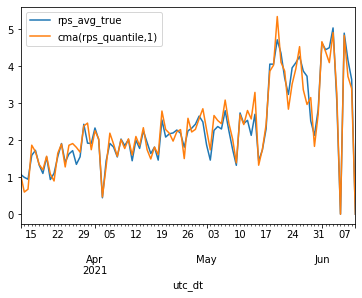

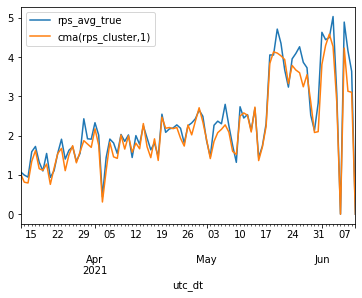

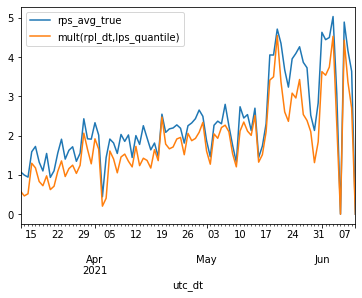

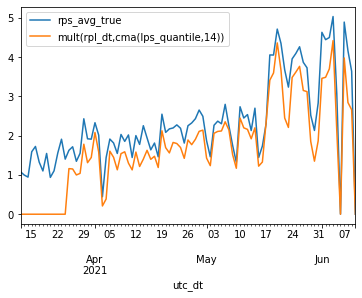

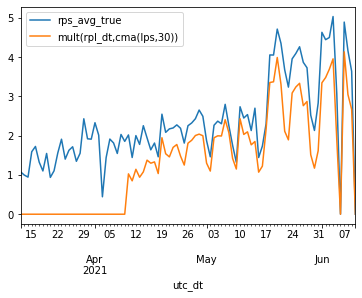

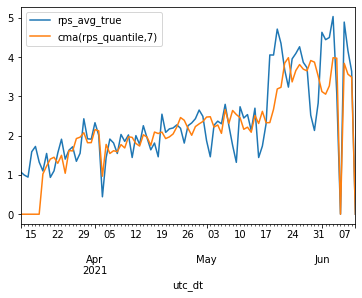

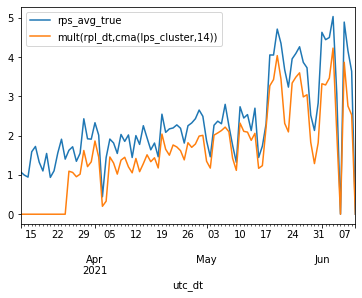

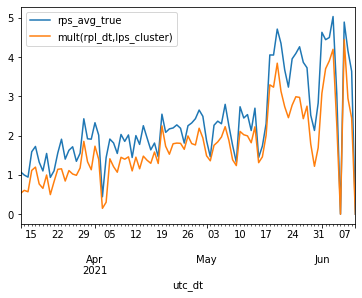

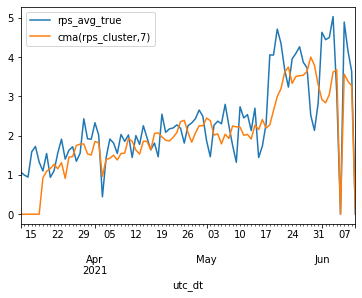

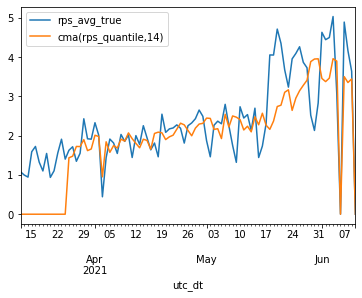

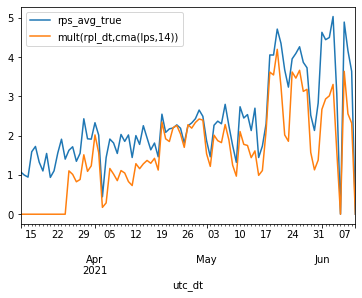

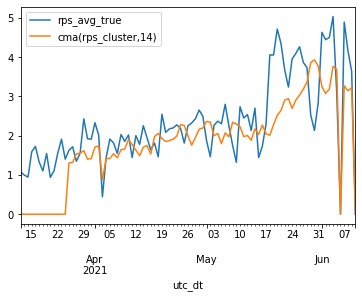

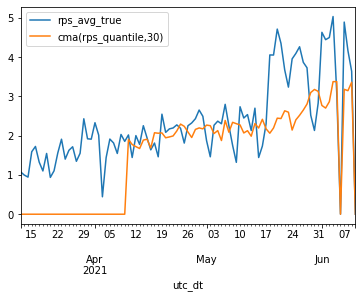

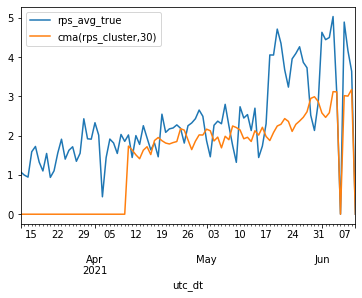

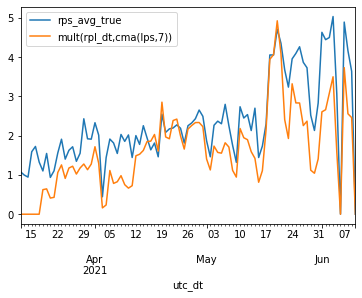

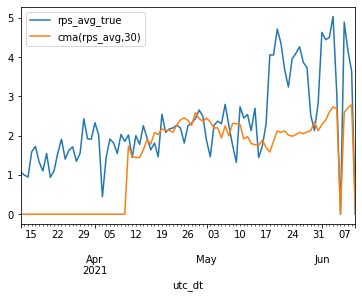

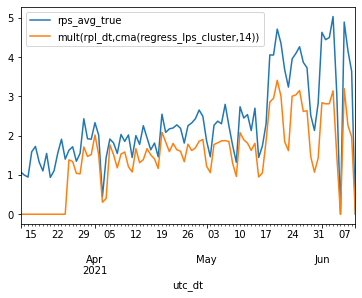

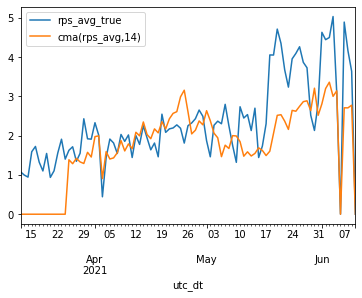

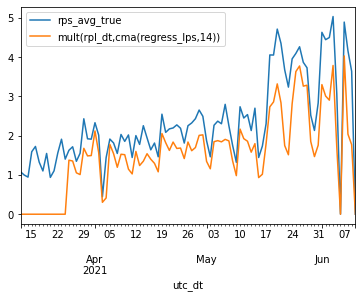

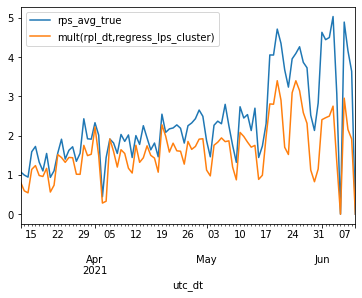

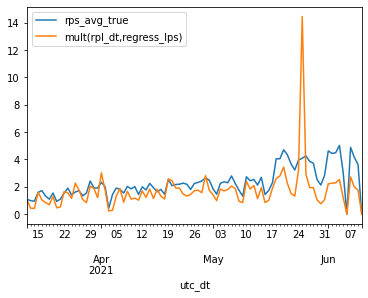

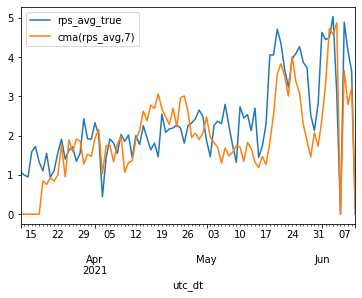

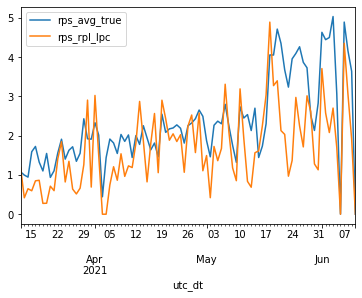

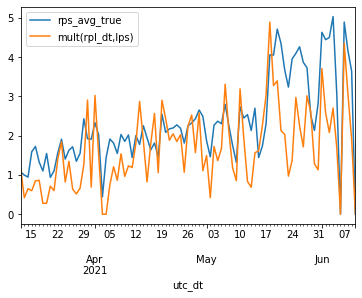

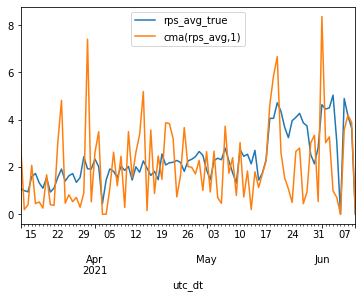

In [53]:
for c in method_perfdf.index:
    rps_df_slc = rps_df \
        .loc[(slice(None),0,slice(None))] \
        
    rps_df_slc \
        .groupby("utc_dt")[["rps_avg_true",c]] \
        .agg(get_wavg_by(rps_df_slc,"sessions")) \
        .plot()
    plt.show()

BING


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


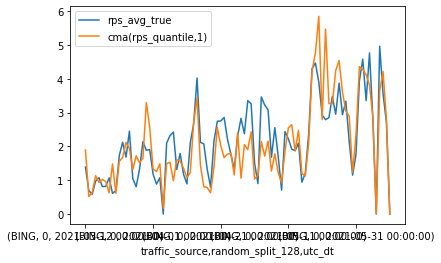

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


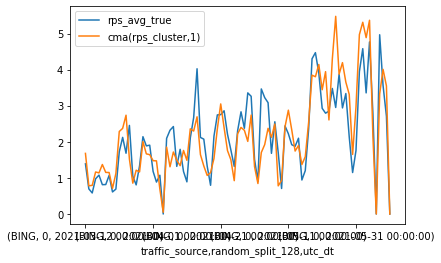

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


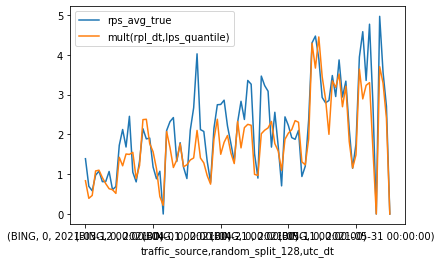

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


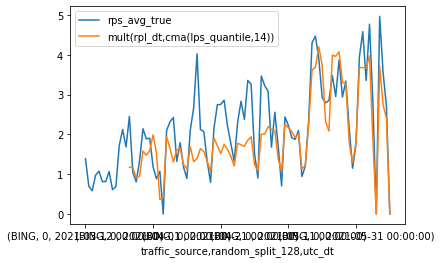

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


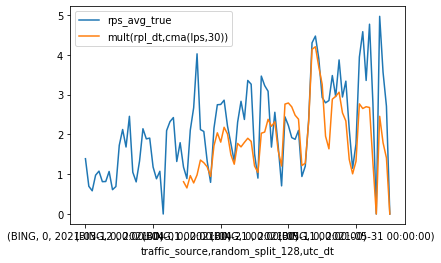

FACEBOOK


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


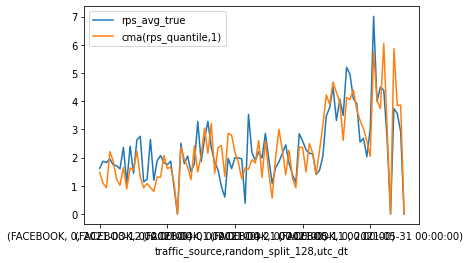

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


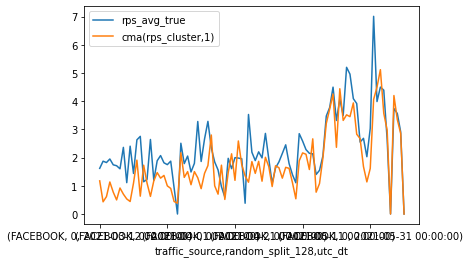

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


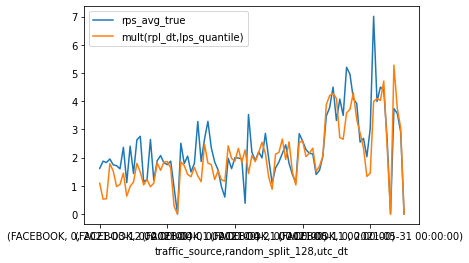

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


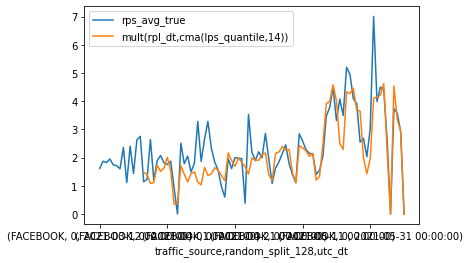

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


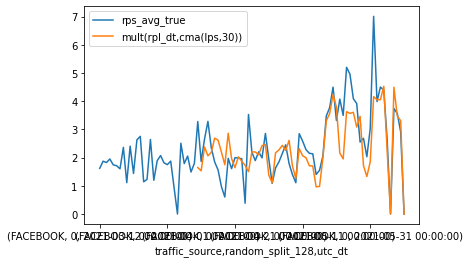

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


GOOGLE


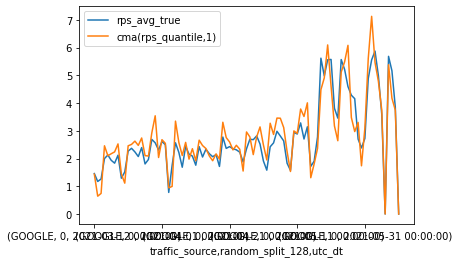

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


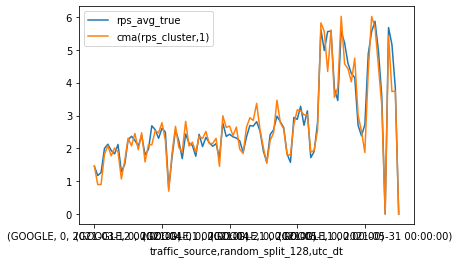

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


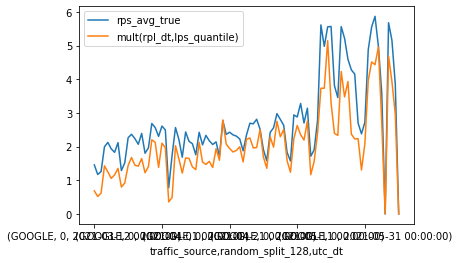

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


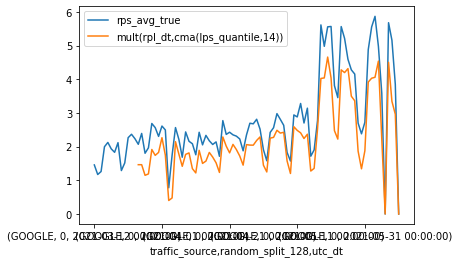

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


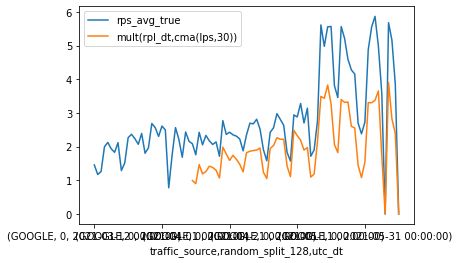

MEDIAALPHA


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


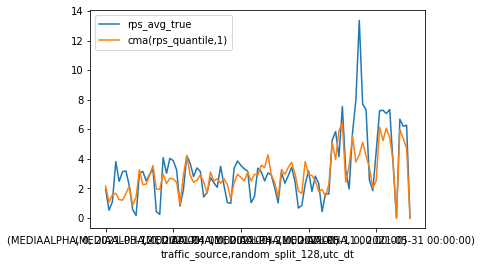

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


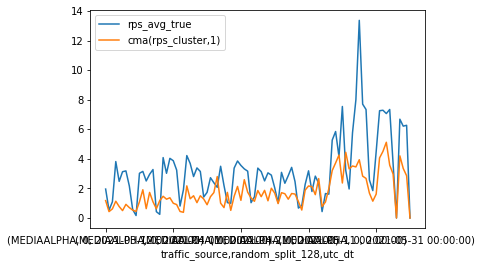

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


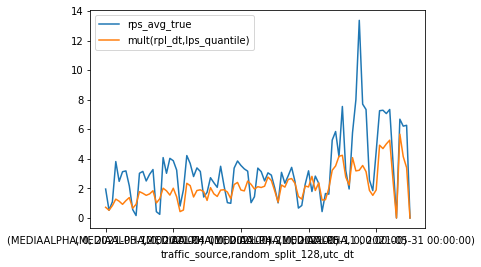

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


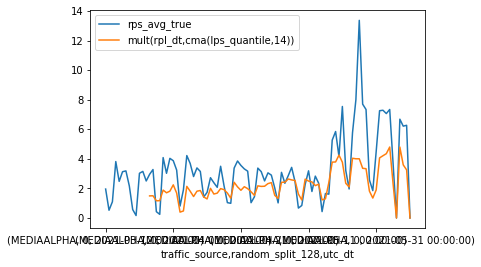

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


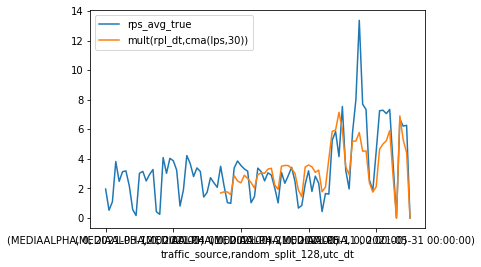

SUREHITS


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


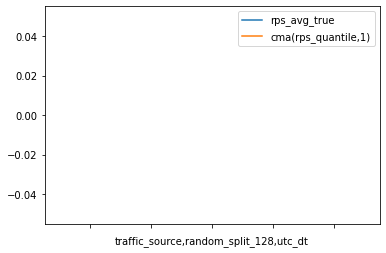

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


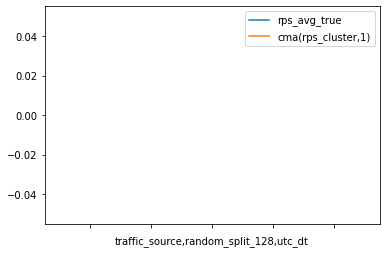

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


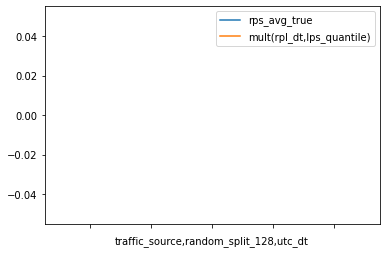

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


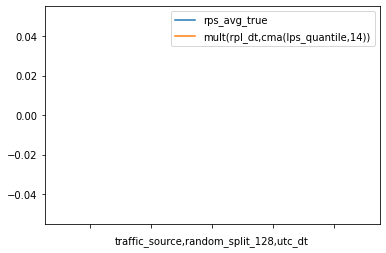

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


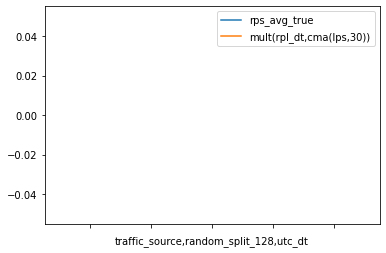

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


TABOOLA


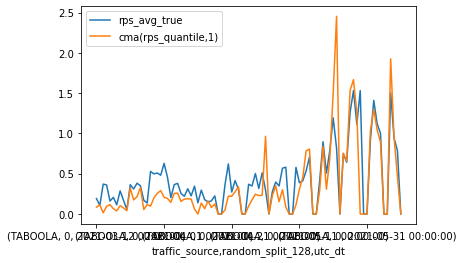

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


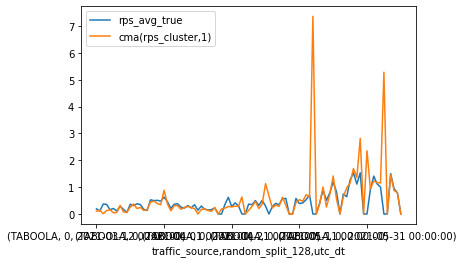

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


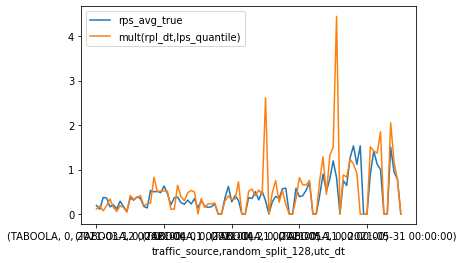

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


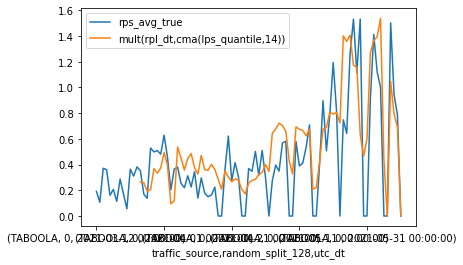

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


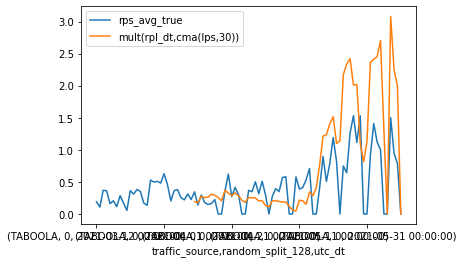

YAHOO


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


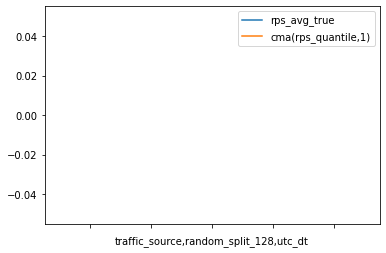

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


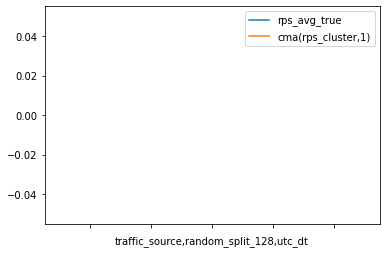

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


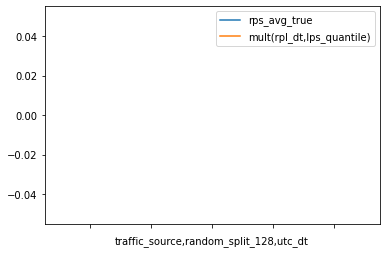

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


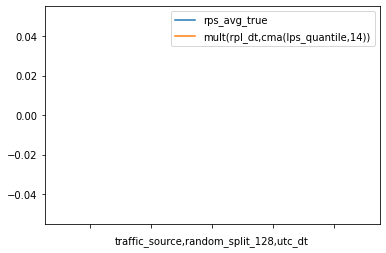

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


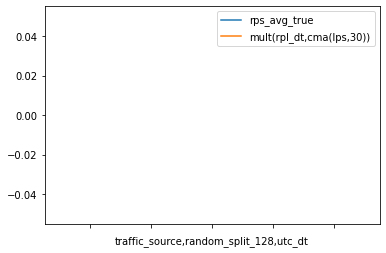

In [39]:
for i in rps_df.index.unique(0):
    print(i)
    for c in method_perfdf.index.values[:5]:
        rps_df.loc[(i,0,slice(None)),["rps_avg_true",c]].plot()
        plt.show()

## Findings
- Clustering can handle both monetization changes and data sparsity issues
- Quantile clustering seems to outperform k-means clustering
- Factoring `RPC` into `RPL * LPC` provides some benefit but is not as good as clustering - although I observed that for some traffic sources `RPL * LPC_cluster` was the best overall approach
- regressing `LPC` into `LPQ * QPL + L0` doesnt provide any benefit
    - I believe this is b/c:
        1. we dont score clicks that arent leads - so regression doesnt help w/ data sparsity
        2. we already have an `RPL` term  that picks up monetization changes - so long term stability of lead scores is not providing an advantage here
    - I think if evaluation method was changed and we had more exctensive lead score data - especially for clicks w/ incomplete surveys - lead score would provide some benefit

In [11]:
start_date,eval_date,end_date

(datetime.date(2021, 3, 11),
 datetime.date(2021, 5, 10),
 datetime.date(2021, 6, 9))

## Next Steps
### 2021-06-07
- want to use similar evaluation method to figure out how many sessions are needed to estimate each var
- Use traffic source as underlying split - not device.
- Evaluate different clustering methods against eachother - e.g. different # of clusters 
- try using 7-day underlying rps as ground truth value - under assumption we will always have active TOD modifiers
- Evaluate effect of switching to direct rps measurement when bucket size sufficiently large
- think about how evaluation method may be forcing results - e.g. this evaluation scenario may way overvalue sensitivity to monetization - try out multiple evaluation methods in the future


### 2021-06-08
- maybe some param to make rpc estimation method sensitive/less-sensitive to monetization changes
- RPL prediction - day forward
- test out rolling windows for clustering / regression
- matplotlib inline
```python
%matplotlib inline
from matplotlib import pyplot as plt
```

### How many observations to measure mean of underlying distribution?

100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


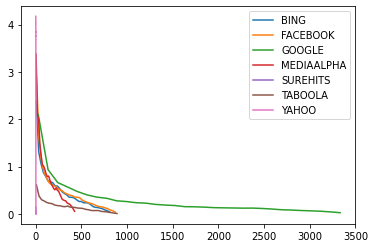

In [54]:
import tqdm
for i in rps_df.index.unique(0):
    X = []; y = []
    for j in tqdm.tqdm(range(0,128,4)):
        rps_slice_df = rps_df.loc[(i,slice(0,j),slice(None))]
        df = rps_slice_df \
            .groupby("utc_dt") \
            .agg({
                "sessions": sum,
                "rps_avg": get_wavg_by(rps_slice_df,"sessions"),
                "rps_avg_true": "first",
            })

        delt = df["rps_avg_true"] - df["rps_avg"]

        X.append(df["sessions"].mean())
        y.append((delt.abs()).mean())

    plt.plot(X,y,label=i)
plt.legend()
plt.show()

100%|██████████| 32/32 [00:05<00:00,  6.14it/s]


<AxesSubplot:xlabel='sessions'>

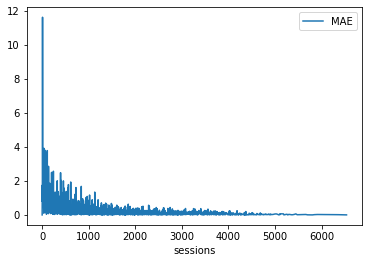

In [55]:
import tqdm
i = "GOOGLE"
X = []; y = []
for j in tqdm.tqdm(range(0,128,4)):
    rps_slice_df = rps_df.loc[(i,slice(0,j),slice(None))]
    df = rps_slice_df \
        .groupby("utc_dt") \
        .agg({
            "sessions": sum,
            "rps_avg": get_wavg_by(rps_slice_df,"sessions"),
            "rps_avg_true": "first",
        })

    delt = df["rps_avg_true"] - df["rps_avg"]
    
    X += df["sessions"].tolist()
    y += delt.abs().tolist()

df = pd.DataFrame(
    np.array(y).reshape(-1,1),columns=["MAE"],
    index=X) \
    .sort_index()
df.index.name = "sessions"
df.groupby("sessions").mean().plot(label=i)

# *DISREGARD BELOW*

OK - basically I think that neither of the 2 conditions under which estimating rps from lead score is useful are met - these are 
1. more session w/ lead score than sessions w/ revenue - instead its the opposite -50k monetization events vs 30k lead scores...
2. a long history of lead score data that would alow us to take advantage of its time stability - we only have a couple months

Think further work will be unproductive until we can either 
1. score sessions w/ no survey (vast majority of session w/ survey have monetization b/c we auction off)
2. score sessions going further back
3. wait a little bit - maybe a couple months

### Alternate rps estimation approach
Goes back to original idea of stabilizing rps w/ lead score  - where you
1. 

In [5]:
split = BEST_SPLIT
rps_mu = wavg(rps_df["rps_avg"],rps_df["sessions"])
rps_split_mu = rps_df["rps_avg"] \
    .groupby(campaign_split_fields[split]) \
    .agg(get_wavg_by(rps_df,"sessions"))
rps_date_mu = rps_df["rps_avg"] \
    .groupby("utc_dt") \
    .agg(get_wavg_by(rps_df,"sessions"))

rps_df["rps_est_date"] = pd.DataFrame(
    (rps_split_mu / rps_mu).values.reshape(-1,1) @ (rps_date_mu.values.reshape(1,-1)),
    columns=rps_date_mu.index,
    index=rps_split_mu.index
).stack()

MemoryError: Unable to allocate 483. GiB for an array with shape (254696, 254696) and data type float64

In [37]:
# product = O65
# df = agg_rps(start_date,end_date,product,traffic_source,("device","utc_dt",))
# print("|df|:",df.shape)
# import pandas as pd
# df = df.reindex(pd.date_range(start_date,end_date),level="utc_dt")
# print("|df|:",df.shape)

In [77]:
import sklearn.linear_model

X = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]]
W = rps_df["sessions"].fillna(0)
y = rps_df["rps_avg"].fillna(0)

X = X.fillna(wavg(X,W))
X = (X - X.mean()) / X.std()
reg = sklearn.linear_model.LinearRegression() \
    .fit(X=X,y=y,sample_weight=W)

rps_df["rps_est_score"] = reg.predict(X)

rps_df

In [ ]:
"""

"""

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


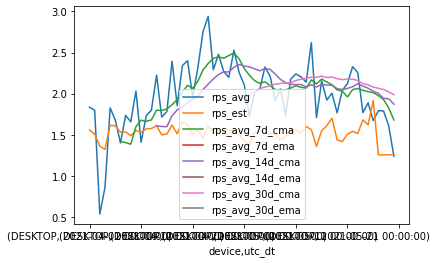

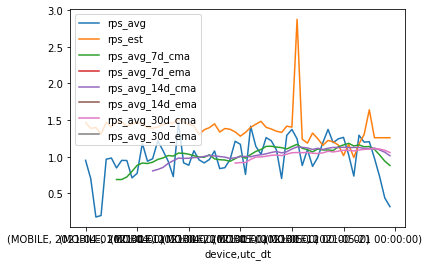

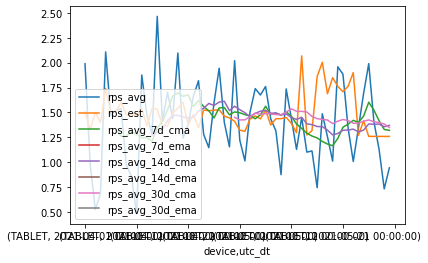

In [38]:
ma_fields = []
for N in [7,14,30]:
    ma_fields += [f"rps_avg_{N}d_cma",f"rps_avg_{N}d_ema"]
import numpy as np
df[ma_fields] = np.NaN
for i in df.index.unique(level=0):
    i = (i,slice(None))
    for N in [7,14,30]:
        df.loc[i,f"rps_avg_{N}d_cma"] = df.loc[i,"rps_avg"].rolling(N).mean()
#         df.loc[i,f"rps_avg_{N}d_ema"] = df.loc[i,"rps_avg"].ewm(com=(N+1)/2).mean()
    df.loc[i,["rps_avg","rps_est",*ma_fields]].plot()

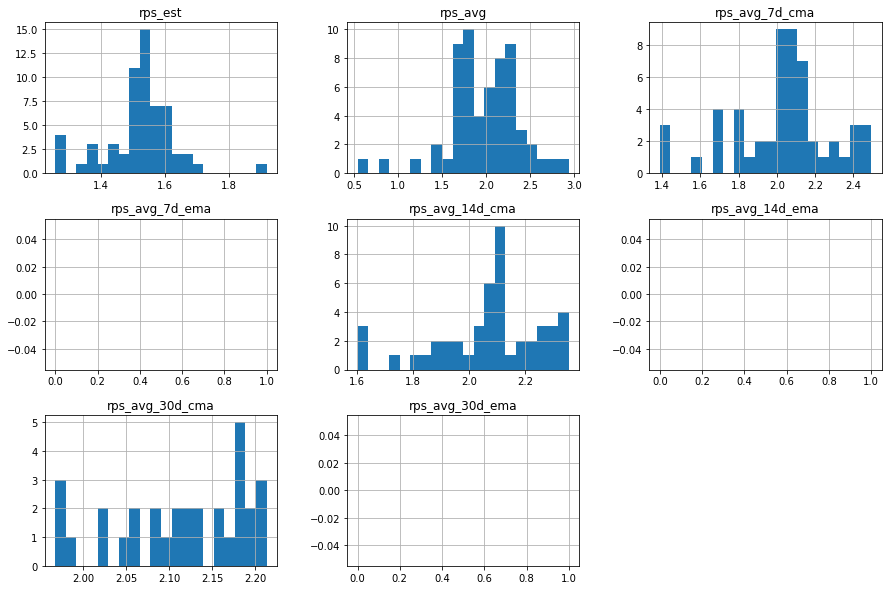

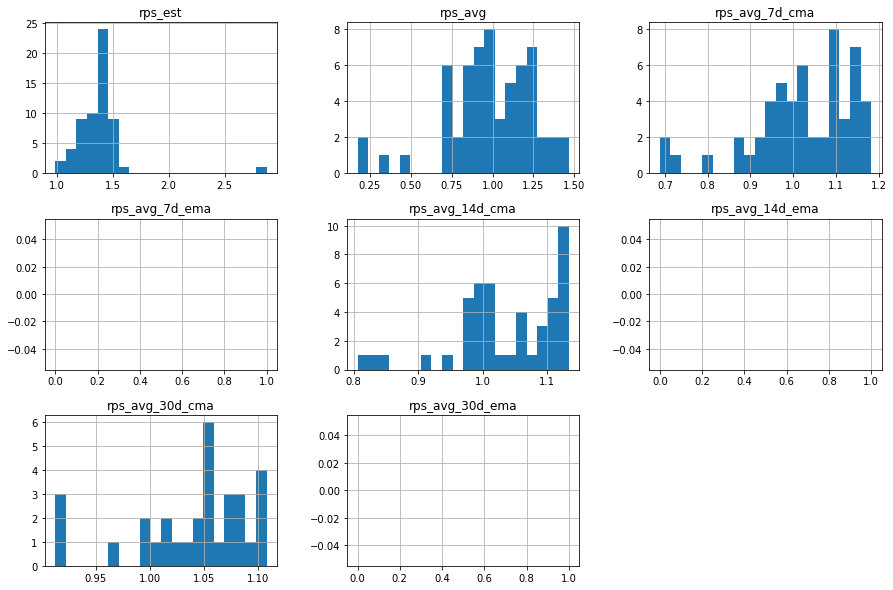

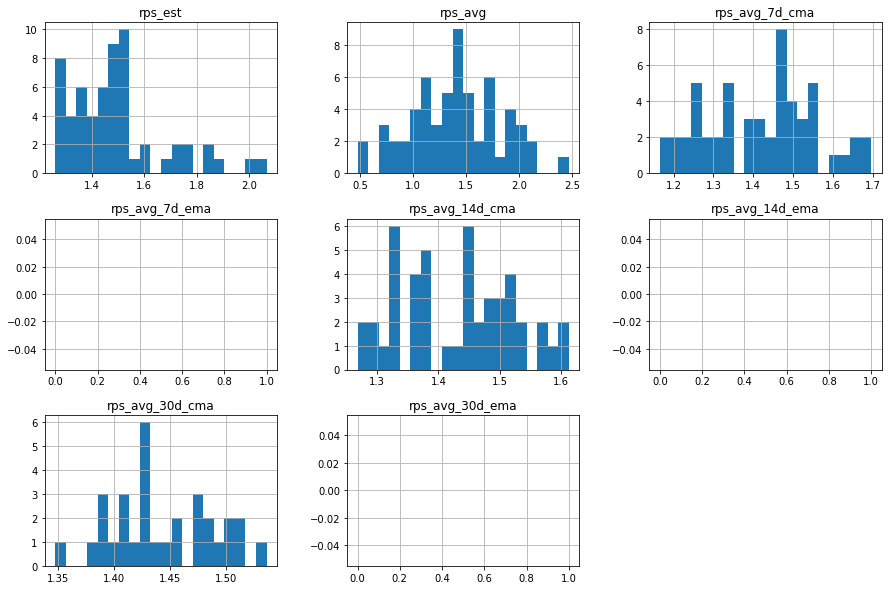

In [39]:
for i in df.index.unique(level=0):
    i = (i,slice(None))
    df.loc[i,["rps_est","rps_avg",*ma_fields]].hist(figsize=(15,10),bins=20)

In [ ]:

campaign_split_fields = dict(
    # traffic_source = ["traffic_source"],
    browser = ["browser"],
    operating_system = ["operating_system"],
    device = ["device"],
    # channel = ["channel"],
    # domain = ["domain"],
    product = ["product"],
    # keyword = ["keyword"],
    # campaign_id = ["campaign_id"],
    # landing_page = ["landing_page"],
    TOD = ["dayofweek","hourofday"],
    dma = ["dma"],
    state =["state",],
    location = ["state","dma"],
    
    dma_os=["dma", "operating_system"],
    dma_device=["dma", "device", ],
    dma_os_device=["dma", "operating_system", "device"],

    state_os=["state", "operating_system"],
    state_device=["state", "device", ],
    state_os_device=["state", "operating_system", "device"],

    location_os = ["state", "dma", "operating_system"],
    location_device=["state", "dma", "device", ],
    location_os_device = ["state", "dma", "operating_system","device"],
)

taboola_val_map = {
    "device": {
        'DESKTOP': 'DESK',
        'MOBILE': 'PHON',
        'TABLET': 'TBLT',
    },
    "operating_system": {
        'Linux armv7l': "Linux",
        'Linux armv8l': "Linux",
        'Linux x86_64': "Linux",
        'MacIntel': 'Mac OS X',
        'Win32': "Windows",
        'iPad': "iPadOS",
        'iPhone': "iOS",
        '': None,
        'ARM': None,
        'Android': 'Android',
        'Linux aarch64': "Linux",
        'Win64': "Windows",
        'Linux armv7': "Linux",
        'Linux i686': "Linux",
        'Windows': "Windows",
    }
}

def translate_taboola_vals(df):
    index_cols = df.index.names
    df = df.reset_index()
    for c in df.columns:
        if c in taboola_val_map:
            df[c] = df[c].apply(taboola_val_map[c].__getitem__)
    df_bkp = df
    df = df \
        .groupby(index_cols) \
        .agg({
            "sessions": sum,
            "num_leads": sum,
            "lps_avg": get_wavg_by(df,"sessions"),
            "rpl_avg": get_wavg_by(df,"sessions"),
            "rps_avg": get_wavg_by(df,"sessions"),
        })
    df["int_ix"] = range(len(df))
    df_bkp_wavg = wavg(df_bkp[["lps_avg","rpl_avg","rps_avg"]],
                        df_bkp["sessions"].values.reshape(-1, 1))
    df_wavg = wavg(df[["lps_avg","rpl_avg","rps_avg"]],
                    df["sessions"].values.reshape(-1, 1))
    assert all((df_bkp_wavg - df_wavg).abs() < 1e-2), (df_bkp_wavg,df_wavg)
    return df

import pprint
from IPython.display import display as ipydisp    
import pandas as pd
from models.utils import wavg
import collections
import itertools

def wvar(V,W):
    mu = wavg(V,W)
    var = wavg((V - mu)**2,W)
    return var
def wstd(V,W):
    return wvar(V,W)**0.5
def get_wavg_by(df, col):
    def wavg_by(V):
        return wavg(V, W=df.loc[V.index, col])
    return wavg_by

def get_wthresh(W,p):
    W = rps_df["sessions"].sort_values(ascending=False)
    Wsum = W.sum()
    cumsum = 0
    for wthresh in W:
        if cumsum > Wsum * p:
            break
        cumsum += wthresh
    return wthresh

"""
TODO: 2021-05-20
  - test fitting on general traffic sources?
  - test clustering on multiple days of rps data - 
      or rolling rps data or something
  - try out more granular aggs
  - is there some kind of metric which measures total variance
      and computes how much of that variance is captured by a split?

Trevor: 2021-05-21
TODO:
- figure out how to minimize campaign # when writing back to taboola
    - want to make sure campaigns have sufficient traffic
- kw=(location,os,device)
- calc 30-day rps/kw
- can create distribution over the rps(kw) distribution
- 100 campaigns - 1 per percentile

TODO: 2021-05-24
- look into clustering each individual split variable
"""

# split2aggrps = {}
# for split,split_cols in campaign_split_fields.items():
#     print(split,split_cols)
#     rps_df = agg_rps(NOW-90*DAY,NOW,None,traffic_source=TABOOLA,agg_columns=split_cols)
#     rps_df = translate_taboola_vals(rps_df)
#     rps_df["split_on"] = split
#     split2aggrps[split] = rps_df
#     print(split,rps_df.shape)


def agg_rps_taboola(start_date, end_date, product, traffic_source, agg_columns):
    rps_df = agg_rps(start_date,end_date,product=product,traffic_source=traffic_source,agg_columns=agg_columns)
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split

split2fitaggrps = {}
for split,split_cols in campaign_split_fields.items():
    print(split,split_cols)
    rps_df = agg_rps(NOW-90*DAY,NOW-30*DAY,None,traffic_source=TABOOLA,agg_columns=tuple(split_cols))
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split
    split2fitaggrps[split] = rps_df

    print(split,rps_df.shape)

split2evalaggrps = {}
for split,split_cols in campaign_split_fields.items():
    print(split,split_cols)
    rps_df = agg_rps(NOW-30*DAY,NOW,None,traffic_source=TABOOLA,agg_columns=tuple(split_cols))
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split
    split2evalaggrps[split] = rps_df

    print(split,rps_df.shape)


In [ ]:

import sklearn.cluster
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
def cluster_split(split):
    rps_df_fit = split2fitaggrps[split]
    rps_df_eval = split2evalaggrps[split]
    split_size = rps_df_fit.__len__()
    MINCLUST = 8
    if split_size <= MINCLUST:
        rps_clust_df = rps_df_eval
        rps_df_fit["clust"] = 0
        rps_df_eval["clust"] = 0
    else:
        # nclust = MINCLUST
        nclust = max(MINCLUST, int(np.log(split_size)))
        # nclust = max(MINCLUST,int(split_size ** 0.5))
        # print("nclust", nclust, split_size, np.log(split_size))
        clusterer = sklearn.cluster.KMeans(n_clusters=nclust)
        rps_df_fit["clust"] = clusterer \
            .fit_predict(
                rps_df_fit["rps_avg"].values.reshape(-1, 1),
                sample_weight=rps_df_fit["sessions"])
        rps_df_eval["clust"] = clusterer \
            .predict(
                rps_df_eval["rps_avg"].values.reshape(-1, 1),
                sample_weight=rps_df_eval["sessions"])
        rps_clust_df = rps_df_eval \
            .groupby("clust") \
            .agg({"rps_avg": get_wavg_by(rps_df_eval, "sessions"), "sessions": sum})
    assert rps_clust_df["rps_avg"].max() <= rps_df_eval["rps_avg"].max()
    rps_wavg = wavg(rps_df_eval["rps_avg"], rps_df_eval["sessions"])
    rps_clust_wavg = wavg(rps_clust_df["rps_avg"], rps_clust_df["sessions"])
    assert abs(rps_wavg - rps_clust_wavg) < 1e-4, (rps_wavg, rps_clust_wavg)
    return rps_df_fit,rps_df_eval,rps_clust_df

def get_split_factor(rps_df):
    orig_index = rps_df.index.names
    split_attr2unique_vals = {index_col: rps_df.index.unique(
        index_col) for index_col in orig_index}
    _,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
    nclusts = rps_df["clust"].unique().__len__()
    split_factor = nclusts * np.prod([1] + [split_attr2unique_vals[c].__len__() for c in new_index_order[:-1]])
    return split_factor

perfD = []
for split in campaign_split_fields.keys():
    rps_df_fit,rps_df_eval,rps_clust_df = cluster_split(split)
    perfd = {
        "split": split,
        "fit_shape": rps_df_fit.shape,
        "clust_shape": rps_clust_df.shape,
        # wavg(rps_df["rps_avg"],rps_df["sessions"]),
        "split_variance": wstd(rps_df_eval["rps_avg"], rps_df_eval["sessions"]),
        "cluster_variance": wstd(rps_clust_df["rps_avg"], rps_clust_df["sessions"]),
        # wstd(rps_df["rps_avg"],rps_df["sessions"])
        "split_factor": rps_df_fit.__len__(),
        "clustered_split_factor": get_split_factor(rps_df_fit),
    }
    perfD.append(perfd)
    pprint.pprint(perfd)
    ipydisp(rps_clust_df)

perfdf = pd.DataFrame(perfD)
ipydisp(perfdf)
#%%
# BEST_SPLIT = "location_os_device"
BEST_SPLIT = "dma_os_device"
# BEST_SPLIT = "dma_os"

rps_df_fit, rps_df_eval, rps_clust_df = cluster_split(BEST_SPLIT)
rps_df = rps_df_fit
get_split_factor(rps_df)
orig_index = rps_df.index.names
split_attr2unique_vals = {index_col: rps_df.index.unique(index_col) for index_col in orig_index}
_,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
rps_df = rps_df .reset_index()
campaign_df = rps_df \
    .groupby([*new_index_order[:-1], "clust"]) \
    .agg({
        "sessions": sum,
        "rps_avg": get_wavg_by(rps_df,"sessions"),
        new_index_order[-1]: tuple
    })
assert campaign_df["sessions"].sum() == rps_df_fit["sessions"].sum()
camp_rps_wavg = wavg(campaign_df["rps_avg"],campaign_df["sessions"])
fit_rps_wavg = wavg(rps_df_fit["rps_avg"], rps_df_fit["sessions"])
assert abs(camp_rps_wavg - fit_rps_wavg) < 1e-5

excl_campaign_df = campaign_df.groupby([*new_index_order[:-1]]) \
    .agg({
        new_index_order[-1]: tuple
    })
def flatten(M):
    return tuple(el for r in M for el in r)
excl_campaign_df[new_index_order[-1]] = excl_campaign_df[new_index_order[-1]] .apply(flatten)

camps = []
for idx,r in campaign_df.iterrows():
    camp = {
        "sessions_60d": r["sessions"], 
        "rps_avg_60d": r["rps_avg"]
    }
    for field,val in zip(new_index_order[:-1],idx):
        camp[field] = {"includes": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "includes": r[last_field]
    }
    camps.append(camp)

for idx, r in excl_campaign_df.iterrows():
    camp = {}
    for field, val in zip(new_index_order[:-1], idx):
        camp[field] = {"includes": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "excludes": r[last_field]
    }
    camps.append(camp)

camp_df = pd.DataFrame(camps)
camp_df.to_csv("campaign_dump.csv")
#%%

import numpy as np
import pandas as pd
import scipy.stats
import sklearn.feature_selection
import sklearn.metrics
from matplotlib import pyplot as plt
import sklearn.preprocessing

requires_campaign_split = [
    # "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]

for split in requires_campaign_split:
    rps_df = split2aggrps[split] .reset_index()
    Xs = rps_df \
        .apply(lambda r: [r["int_ix"]]*int(r["sessions"]), axis=1)
    X = np.concatenate(Xs.values).reshape(-1,1)
    ys = rps_df \
        .apply(lambda r: [r["rps_avg"]]*int(r["sessions"]),axis=1)
    y = np.concatenate(ys.values)
    # print(y.min(),np.quantile(y, 0.5),y.max())
    y = y > y.mean()
    # y = np.concatenate(ys.values).reshape(-1,1)
    # y = sklearn.preprocessing.KBinsDiscretizer(n_bins=2,encode="ordinal") \
    #     .fit_transform(y).reshape(-1)
    mi = sklearn.feature_selection.mutual_info_regression(X,y,discrete_features=True)
    print(split,mi,y.mean(),rps_df.shape)
#%%
y
#%%
sklearn.metrics.mutual_info_score

#%%
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt

requires_campaign_split = [
    "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]
combined_rps_df = pd.concat([df.reset_index() for df in split2aggrps.values()])
splitI = combined_rps_df["split_on"].isin(requires_campaign_split)
density = scipy.stats.gaussian_kde(
    dataset=combined_rps_df.loc[splitI,"rps_avg"],
    weights=combined_rps_df.loc[splitI, "sessions"],
    # bw_method="scott",
    # bw_method="silverman",
    # bw_method=0.1,
)
xs = np.linspace(0,2,100)
plt.plot(xs,density(xs))
#%%
for split in requires_campaign_split:
    splitI = combined_rps_df["split_on"] == split
    density = scipy.stats.gaussian_kde(
        dataset=combined_rps_df.loc[splitI, "rps_avg"],
        weights=combined_rps_df.loc[splitI, "sessions"])
    xs = np.linspace(0, 2, 100)
    plt.plot(xs, density(xs))
    plt.title(split)
    plt.show()
#%%
combined_rps_df.loc[splitI, ["rps_avg","sessions"]].apply(
        lambda r: pd.Series([r["rps_avg"]]*int(r["sessions"])),axis=1) \
    .unstack()
#%%
agg_rps = split2aggrps["TOD"]
Xy = agg_rps[["sessions","rps"]].reset_index()
Xy["i"] = range(len(Xy))
Xy
#%%
import sklearn.feature_selection
sklearn.feature_selection.mutual_info_regression(
    []
)

#%%
"""
- 
- overall goal:
    - specific ROI targetting w/ minimal campaigns
- what this means for accnt structure
    - for many variables we must split campaigns to target ROI
    - want to capture greatest amt of rps variation w/ 
        fewest # of campaigns
- 2 ways of approaching this
    1. minimize rps variation w/in a campaign
        - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
        - tried this out a little - but the computation was intensive which made it slow going
    2. maximize rps variation outside campaigns
    - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    - mostly focused on this approach

- approaches I tried
1. rank splits by their correlation/covaraince/MI w/ `agg_rps`
    - tried ANOVA,pt.biserial,MI - had most success w/ MI
    - was dificult to compute b/c couldnt find methods that accepted sample weight
    - MI approach was promising but didnt go down that route
2. rank splits by intra-split agg_rps variance
    - had most success w/ this
    - tested out an approahc where I cluster the split on rps - had good results
    - think this is the mtd to use going forward
    TODO:
    - test fitting on general traffic sources?
    - test clustering on multiple days of rps data - 
        or rolling rps data or something
    - try out more granular aggs
    - is there some kind of metric which measures total variance
        and computes how much of that variance is captured by a split?

3. fit decision tree on rps data 
    - MSE criterion is apparently the same as minimizng inter split variance
    - computationally intensive
    - not 100% clear how to go from tree to campaign structure


- can do this by
    1. choosing what vars or tuples of vars to split campaigns on
    2. grouping similar buckets w/in those splits
- want to measure correlation/dependence of categorical split vars w/ cont rps
    - cat,cat metrics w/ binned rps
        chi
    - cont,cont metrcs w/ 1 hot encoded split vars
    - cat,cont metrics
- correlation metrics
    - MI:
        - sklearn.feature_selection.mi_regression
        - would need AFAICT to rresample input arrays
    - ANOVA:
        - scipy.stats.f_oneway
    - pt biserial
        - needs binary vars tho
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
        - https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
- want most variation of rps w/ fewest camapaigns
- dont want to group similar buckets together - think its too complicated

"""
#%%
requires_campaign_split = [
    "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    "domain",
    "product",
    "landing_page",
    "location",
]
#%%

traffic_source = TABOOLA
with HealthcareDW() as db:
    traffic_filter = "" if traffic_source is None else \
        f"AND UPPER(traffic_source) = UPPER('{traffic_source}')"
    sql = f"""
    select
        traffic_source,domain,count(*)
    from tracking.session_detail
    where True 
    {traffic_filter}
    group by traffic_source,domain;
    """
    df = db.to_df(sql).sort_values("count")
df
#%%

# %%
with HealthcareDW() as db:


In [ ]:
# Header

